## PROJECT: Predicting Student Success and Financial Outcomes in Higher Education
## TEAM: Group 12 (ECE 143)

### 1. SETUP & MOUNT DRIVE

In [11]:
import pandas as pd
import numpy as np
import glob
import os
#from google.colab import drive

#drive.mount('/content/drive')

# Paths
#RAW_DATA_PATH = '/content/drive/MyDrive/ECE143/College_Scorecard_Raw_Data_10032025/'
RAW_DATA_PATH = './College_Scorecard_Raw_Data_10032025/'
OUTPUT_PATH = './'
#OUTPUT_PATH = '/content/drive/MyDrive/ECE143'

### 2. COLUMN SELECTION

In [12]:
COLS_TO_KEEP = [
    # Metadata
    'UNITID',      # Unit ID
    'INSTNM',      # Institution Name
    'CITY',        # City
    'STABBR',      # State

    # Institutional Characteristics
    'CONTROL',     # 1=Public, 2=Private nonprofit, 3=Private for-profit
    'ADM_RATE',    # Admission Rate
    'UGDS',        # Undergraduate Enrollment (Size)

    # Cost
    'COSTT4_A',    # Average Cost of Attendance (Academic Year)
    'TUITIONFEE_IN',   # In-state Tuition
    'TUITIONFEE_OUT',  # Out-of-state Tuition

    # Net Price by Income (Public & Private separate in raw data)
    'NPT41_PUB', 'NPT42_PUB', 'NPT43_PUB', 'NPT44_PUB', 'NPT45_PUB',
    'NPT41_PRIV', 'NPT42_PRIV', 'NPT43_PRIV', 'NPT44_PRIV', 'NPT45_PRIV',

    # Success Outcomes
    'C150_4',      # Completion Rate (4-year institutions)

    # Financial Outcomes (Earnings & Debt)
    'MD_EARN_WNE_P6',      # Median Earnings (6 years after entry)
    'MD_EARN_WNE_P10',     # Median Earnings (10 years after entry)
    'GRAD_DEBT_MDN_SUPP',  # Median Debt of Graduates
    'DEBT_MDN_SUPP'        # Median Debt of All Students
]

### 3. PROCESSING FUNCTIONS

In [13]:
def load_and_merge_years(folder_path, cols):
    """
    Load and merge all MERGED*_PP.csv files from the folder.
    """
    all_files = sorted(glob.glob(os.path.join(folder_path, "MERGED*_PP.csv")))

    if len(all_files) == 0:
        print("No CSV files found!")
        return None

    print(f"Found {len(all_files)} files. Starting load process...")

    df_list = []
    for filename in all_files:
        base_name = os.path.basename(filename)
        year_str = base_name.replace('MERGED', '').replace('_PP.csv', '')

        try:
            df_temp = pd.read_csv(filename, usecols=lambda x: x in cols, low_memory=False)
            df_temp['YEAR'] = year_str
            df_list.append(df_temp)
        except ValueError:
            continue

    if not df_list:
        return None

    full_df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded {len(full_df):,} records from {len(df_list)} files")
    return full_df

In [14]:
def clean_dataframe(df):

    print("\n" + "="*70)
    print("DATA CLEANING PROCESS (FIXED VERSION)")
    print("="*70)

    # Step 1: Replace 'PrivacySuppressed'
    df.replace('PrivacySuppressed', np.nan, inplace=True)
    print("[Step 1] Replaced 'PrivacySuppressed' with NaN")

    # Step 2: Convert to numeric
    text_cols = ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'YEAR']
    numeric_cols = [c for c in df.columns if c not in text_cols]

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    print(f"[Step 2] Converted {len(numeric_cols)} columns to numeric type")

    # Step 3: Consolidate Net Price
    for i in range(1, 6):
        pub_col = f'NPT4{i}_PUB'
        priv_col = f'NPT4{i}_PRIV'
        new_col = f'NET_PRICE_Q{i}'
        if pub_col in df.columns and priv_col in df.columns:
            df[new_col] = df[pub_col].fillna(df[priv_col])

    drop_cols = [c for c in df.columns if 'NPT4' in c]
    df.drop(columns=drop_cols, inplace=True)
    print("[Step 3] Consolidated Net Price columns...")

    CRITICAL_COLUMNS = [
        'MD_EARN_WNE_P10',
        'MD_EARN_WNE_P6',
        'ADM_RATE',
        'C150_4',
        'COSTT4_A',
        'GRAD_DEBT_MDN_SUPP'
    ]

    missing_pct = (df.isnull().sum() / len(df) * 100)

    cols_to_drop = missing_pct[missing_pct > 50].index.tolist()

    final_drop_list = [c for c in cols_to_drop if c not in CRITICAL_COLUMNS]

    if final_drop_list:
        df.drop(columns=final_drop_list, inplace=True)
        print(f"\n[Step 5] Dropped {len(final_drop_list)} non-critical columns with >50% missing data.")
        print(f"Dropped: {final_drop_list}")
    else:
        print("\n[Step 5] No columns dropped (Critical columns protected).")

    print("\n--- Status of Critical Variables ---")
    for col in CRITICAL_COLUMNS:
        if col in df.columns:
            print(f" Kept {col} (Missing: {missing_pct[col]:.1f}%)")
        else:
            print(f" Error: {col} is missing from dataframe!")

    return df

In [15]:
def validate_data(df):
    """
    Perform data quality checks.
    """
    # Check duplicates
    if 'UNITID' in df.columns and 'YEAR' in df.columns:
        duplicates = df.duplicated(subset=['UNITID', 'YEAR']).sum()
        print(f"Duplicate (UNITID, YEAR) pairs: {duplicates}")

    # Check admission rates
    if 'ADM_RATE' in df.columns:
        invalid = ((df['ADM_RATE'] < 0) | (df['ADM_RATE'] > 1)).sum()
        if invalid == 0:
            print("Admission rates valid (all in [0,1])")
        else:
            print(f"Invalid admission rates: {invalid}")

    # Check completion rates
    if 'C150_4' in df.columns:
        invalid = ((df['C150_4'] < 0) | (df['C150_4'] > 1)).sum()
        if invalid == 0:
            print("Completion rates valid (all in [0,1])")
        else:
            print(f"Invalid completion rates: {invalid}")

In [16]:
def add_derived_features(df):
    """
    Create derived features for analysis.
    """

    # 1. Average Net Price
    net_price_cols = [f'NET_PRICE_Q{i}' for i in range(1, 6)]
    existing = [col for col in net_price_cols if col in df.columns]
    if existing:
        df['AVG_NET_PRICE'] = df[existing].mean(axis=1)
        print(f"→ AVG_NET_PRICE from {len(existing)} columns")
    else:
        print("NET_PRICE columns not found")

    # 2. Debt-to-Earnings Ratio
    if 'GRAD_DEBT_MDN_SUPP' in df.columns and 'MD_EARN_WNE_P6' in df.columns:
        df['DEBT_TO_EARNINGS'] = df['GRAD_DEBT_MDN_SUPP'] / df['MD_EARN_WNE_P6'].replace(0, np.nan)
        print("→ DEBT_TO_EARNINGS")
    else:
        print("Required columns for DEBT_TO_EARNINGS not found")

    # 3. ROI (10-year)
    if 'MD_EARN_WNE_P10' in df.columns and 'COSTT4_A' in df.columns:
        df['ROI_10YR'] = ((df['MD_EARN_WNE_P10'] * 10) - (df['COSTT4_A'] * 4)) / (df['COSTT4_A'] * 4).replace(0, np.nan)
        print("→ ROI_10YR")
    else:
        print("Required columns for ROI_10YR not found")

    # 4. Size Category
    if 'UGDS' in df.columns:
        df['SIZE_CATEGORY'] = pd.cut(df['UGDS'],
                                       bins=[0, 1000, 5000, 15000, float('inf')],
                                       labels=['Small', 'Medium', 'Large', 'Very Large'])
        print("→ SIZE_CATEGORY")
    else:
        print("UGDS column not found")

    # 5. Selectivity
    if 'ADM_RATE' in df.columns:
        df['SELECTIVITY'] = pd.cut(df['ADM_RATE'],
                                     bins=[0, 0.25, 0.50, 0.75, 1.0],
                                     labels=['Highly Selective', 'Selective',
                                            'Moderately Selective', 'Open Admission'])
        print("→ SELECTIVITY")
    else:
        print("ADM_RATE column not found")

    # Count features added
    features_added = sum([
        'AVG_NET_PRICE' in df.columns,
        'DEBT_TO_EARNINGS' in df.columns,
        'ROI_10YR' in df.columns,
        'SIZE_CATEGORY' in df.columns,
        'SELECTIVITY' in df.columns
    ])

    print(f"Successfully added {features_added}/5 derived features")
    return df

In [17]:
def filter_valid_institutions(df):
    """
    Filter institutions with sufficient data for analysis.
    """
    initial_count = len(df)

    # Keep only records with required columns
    required_cols = ['UNITID', 'INSTNM', 'YEAR', 'CONTROL']
    df = df.dropna(subset=required_cols)

    # Remove very small institutions
    if 'UGDS' in df.columns:
        df = df[df['UGDS'] >= 100]  # At least 100 students

    final_count = len(df)
    print(f"→ Kept {final_count:,}/{initial_count:,} records ({final_count/initial_count*100:.1f}%)")

    return df

### *EXECUTION*

In [18]:
def quick_eda(df):
    """
    Quick exploratory data analysis.
    """
    print("\n" + "="*60)
    print("QUICK EXPLORATORY DATA ANALYSIS")
    print("="*60)

    # Institution types
    if 'CONTROL' in df.columns:
        print("\nInstitution Type Distribution:")
        print(df['CONTROL'].value_counts())
        print("(1.0=Public, 2.0=Private nonprofit, 3.0=Private for-profit)")

    # Year coverage
    if 'YEAR' in df.columns:
        years = sorted(df['YEAR'].unique())
        print(f"\nYear Range: {min(years)} - {max(years)}")
        print(f"Total years: {len(years)}")

    # Key metrics summary
    key_metrics = ['ADM_RATE', 'C150_4', 'MD_EARN_WNE_P6', 'GRAD_DEBT_MDN_SUPP']
    available = [c for c in key_metrics if c in df.columns]
    if available:
        print("\nKey Metrics Summary:")
        print(df[available].describe())

    print("="*60)

In [19]:
print("="*60)
print("COLLEGE SCORECARD DATA PROCESSING PIPELINE")
print("="*60)

try:
    # Step A: Load
    print("\n[Step A] Loading data...")
    raw_df = load_and_merge_years(RAW_DATA_PATH, COLS_TO_KEEP)

    if raw_df is not None:
        # Step B: Clean
        print("\n[Step B] Cleaning data...")
        clean_df = clean_dataframe(raw_df)

        # Step C: Validate
        print("\n[Step C] Validating data...")
        validate_data(clean_df)

        # Step D: Add Features
        print("\n[Step D] Adding derived features...")
        try:
            clean_df = add_derived_features(clean_df)
        except Exception as e:
            print(f"Error in add_derived_features: {e}")
            print("Continuing without derived features...")

        # Step E: Filter
        print("\n[Step E] Filtering institutions...")
        try:
            clean_df = filter_valid_institutions(clean_df)
        except Exception as e:
            print(f"Error in filter_valid_institutions: {e}")
            print("Continuing without filtering...")

        # Step F: Quick EDA
        print("\n[Step F] Running quick EDA...")
        quick_eda(clean_df)

        # Step G: Save
        print("\n[Step G] Saving cleaned data...")
        output_file = os.path.join(OUTPUT_PATH, 'ECE143_Project_Cleaned_Data.csv')
        clean_df.to_csv(output_file, index=False)

        print(f"\n{'='*60}")
        print("SUCCESS!")
        print(f"{'='*60}")
        print(f"File: {output_file}")
        print(f"Shape: {len(clean_df):,} rows × {len(clean_df.columns)} columns")
        print(f"{'='*60}")

        # Display first few rows
        display(clean_df.head())

except Exception as e:
    print(f"\n ERROR: {e}")
    import traceback
    traceback.print_exc()

COLLEGE SCORECARD DATA PROCESSING PIPELINE

[Step A] Loading data...
Found 28 files. Starting load process...
Loaded 196,163 records from 28 files

[Step B] Cleaning data...

DATA CLEANING PROCESS (FIXED VERSION)
[Step 1] Replaced 'PrivacySuppressed' with NaN
[Step 2] Converted 21 columns to numeric type
[Step 3] Consolidated Net Price columns...

[Step 5] Dropped 6 non-critical columns with >50% missing data.
Dropped: ['TUITIONFEE_OUT', 'NET_PRICE_Q1', 'NET_PRICE_Q2', 'NET_PRICE_Q3', 'NET_PRICE_Q4', 'NET_PRICE_Q5']

--- Status of Critical Variables ---
 Kept MD_EARN_WNE_P10 (Missing: 79.4%)
 Kept MD_EARN_WNE_P6 (Missing: 73.0%)
 Kept ADM_RATE (Missing: 72.1%)
 Kept C150_4 (Missing: 70.2%)
 Kept COSTT4_A (Missing: 71.6%)
 Kept GRAD_DEBT_MDN_SUPP (Missing: 38.8%)

[Step C] Validating data...
Duplicate (UNITID, YEAR) pairs: 0
Admission rates valid (all in [0,1])
Completion rates valid (all in [0,1])

[Step D] Adding derived features...
NET_PRICE columns not found
→ DEBT_TO_EARNINGS
→ ROI

UNITID                                  INSTNM        CITY STABBR  CONTROL  \
0  100636      Community College of the Air Force  Montgomery     AL      1.0   
1  100654                Alabama A & M University      Normal     AL      1.0   
2  100663     University of Alabama at Birmingham  Birmingham     AL      1.0   
3  100672  ALABAMA AVIATION AND TECHNICAL COLLEGE       OZARK     AL      1.0   
5  100706     University of Alabama in Huntsville  Huntsville     AL      1.0   

   ADM_RATE     UGDS  COSTT4_A  TUITIONFEE_IN  C150_4  MD_EARN_WNE_P10  \
0       NaN  44141.0       NaN            NaN     NaN              NaN   
1       NaN   3852.0       NaN            NaN     NaN              NaN   
2       NaN   9889.0       NaN            NaN     NaN              NaN   
3       NaN    295.0       NaN            NaN     NaN              NaN   
5       NaN   3854.0       NaN            NaN     NaN              NaN   

   MD_EARN_WNE_P6  DEBT_MDN_SUPP  GRAD_DEBT_MDN_SUPP     YEAR  \
0             NaN            NaN                 NaN  1996_97   
1             NaN            NaN                 NaN  1996_97   
2             NaN            NaN                 NaN  1996_97   
3             NaN            NaN                 NaN  1996_97   
5             NaN            NaN                 NaN  1996_97   

   DEBT_TO_EARNINGS  ROI_10YR SIZE_CATEGORY SELECTIVITY  
0               NaN       NaN    Very Large         NaN  
1               NaN       NaN        Medium         NaN  
2               NaN       NaN         Large         NaN  
3               NaN       NaN         Small         NaN  
5               NaN       NaN        Medium         NaN

# Model Building

In [10]:
# ==============================================================================
# PART 1: RANDOM FOREST REGRESSOR (Predicting ROI)
# Goal: Build a robust non-linear model to predict 10-Year ROI
# ==============================================================================

In [21]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
import numpy as np

In [22]:
# ------------------------------------------------------------------------------
# STEP 1: Data Cleaning & Feature Selection (Prevent Leakage)
# ------------------------------------------------------------------------------


clean_df = pd.read_csv(OUTPUT_PATH + '/ECE143_Project_Cleaned_Data.csv')

# Keep
df_model = clean_df[clean_df["ROI_10YR"].notna()].copy()
# Drop rows with too many missing core values
core_num = [
    "COSTT4_A",
    "TUITIONFEE_IN",
    "UGDS",
    "DEBT_MDN_SUPP",
    "GRAD_DEBT_MDN_SUPP",
    "ADM_RATE",
    "C150_4"
]
missing_count = df_model[core_num].isna().sum(axis=1)
df_model = df_model[missing_count < 2].copy()
df_model = df_model.reset_index(drop=True)

# Define Target (y) and Features (X)
# CRITICAL: Drop "leaky" columns (Earnings, Debt) that directly calculate ROI

y = df_model["ROI_10YR"]

id_cols = ["UNITID", "INSTNM", "CITY", "YEAR"]
leaky_cols = ["MD_EARN_WNE_P10", "COSTT4_A", "DEBT_TO_EARNINGS", "MD_EARN_WNE_P6"]
## leaky_cols = ["MD_EARN_WNE_P10", "COSTT4_A"]


X = df_model.drop(columns=id_cols + leaky_cols + ["ROI_10YR"]).copy()

In [23]:
# ------------------------------------------------------------------------------
# STEP 2: Preprocessing (Categorical Encoding)
# ------------------------------------------------------------------------------

categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols_original = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Fill missing categoricals and apply One-Hot Encoding
for col in categorical_cols:
    X[col] = X[col].astype("object")
    X[col] = X[col].fillna("Missing")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [24]:
# ------------------------------------------------------------------------------
# STEP 3: Train-Test Split (Group-Aware to prevent Data Leakage)
# ------------------------------------------------------------------------------
# We split by 'UNITID' so the same school appears ONLY in Train OR Test, never both.

groups = df_model["UNITID"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_encoded, y, groups=groups))

X_train = X_encoded.iloc[train_idx]
X_test = X_encoded.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

In [25]:
# ------------------------------------------------------------------------------
# STEP 4: Numeric Imputation (Using Training Medians)
# ------------------------------------------------------------------------------

cols_to_impute = [c for c in numeric_cols_original if c in X_train.columns]

for col in cols_to_impute:
    med = X_train[col].median()
    X_train[col] = X_train[col].fillna(med)
    X_test[col] = X_test[col].fillna(med)

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3269042540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3269042540.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3269042540.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [26]:
# ------------------------------------------------------------------------------
# STEP 5: Model Training (Random Forest with Hyperparameter Tuning)
# ------------------------------------------------------------------------------


base_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": randint(100, 501),
    "max_depth": [None, 5, 10, 15, 20, 30],
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 11),
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
}

gkf = GroupKFold(n_splits=5)

rf_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=40,
    cv=gkf,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Running RandomizedSearchCV for RandomForestRegressor...")
rf_search.fit(X_train, y_train, groups=groups_train)

best_params = rf_search.best_params_
print("\n=== Random search results (RF regressor) ===")
print("Best params:", best_params)
print(f"Best CV MAE (neg): {rf_search.best_score_:.4f}")
print(f"Best CV MAE:       {-rf_search.best_score_:.4f}")

Running RandomizedSearchCV for RandomForestRegressor...
Fitting 5 folds for each of 40 candidates, totalling 200 fits



=== Random search results (RF regressor) ===
Best params: {'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 229}
Best CV MAE (neg): -0.5875
Best CV MAE:       0.5875


In [27]:
# ------------------------------------------------------------------------------
# STEP 6: Evaluation & Feature Importance
# ------------------------------------------------------------------------------

rf_final = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

print("\n=== Test set evaluation (RF regressor) ===")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# Extract Top Features
print("\nBase features before encoding:", X.columns.tolist())
print("Number of base features:", len(X.columns))
print("Encoded shape:", X_encoded.shape)

importances = rf_final.feature_importances_
feature_names = X_train.columns

idx = np.argsort(importances)[::-1]
top_k = 15

print("\nTop feature importances (RF regressor):")
for i in range(top_k):
    print(f"{i+1:2d}. {feature_names[idx[i]]}: {importances[idx[i]]:.4f}")


=== Test set evaluation (RF regressor) ===
MAE: 0.5512921482461899
R²: 0.7399825824270418

Base features before encoding: ['STABBR', 'CONTROL', 'ADM_RATE', 'UGDS', 'TUITIONFEE_IN', 'C150_4', 'DEBT_MDN_SUPP', 'GRAD_DEBT_MDN_SUPP', 'SIZE_CATEGORY', 'SELECTIVITY']
Number of base features: 10
Encoded shape: (13735, 67)

Top feature importances (RF regressor):
 1. TUITIONFEE_IN: 0.3110
 2. CONTROL: 0.2702
 3. GRAD_DEBT_MDN_SUPP: 0.0822
 4. UGDS: 0.0777
 5. DEBT_MDN_SUPP: 0.0553
 6. C150_4: 0.0522
 7. ADM_RATE: 0.0287
 8. STABBR_NY: 0.0123
 9. SIZE_CATEGORY_Small: 0.0085
10. SIZE_CATEGORY_Very Large: 0.0084
11. SELECTIVITY_Missing: 0.0081
12. STABBR_CT: 0.0060
13. SIZE_CATEGORY_Medium: 0.0053
14. STABBR_OH: 0.0046
15. STABBR_PR: 0.0038


# Random Forest Regression Results

## 1. Hyperparameter Tuning (RandomizedSearchCV)
The model was optimized using random search. The best configuration achieved a Cross-Validation MAE of **0.5868**.

* **Best Parameters:**
    ```python
    {
      'n_estimators': 229,
      'max_features': 0.3,
      'min_samples_leaf': 1,
      'min_samples_split': 3,
      'max_depth': None
    }
    ```

## 2. Model Performance (Test Set)
The model explains approximately **74%** of the variance in the target variable, indicating strong predictive power.

| Metric | Value |
| :--- | :--- |
| **MAE** | 0.5514 |
| **$R^2$ Score** | **0.7394** |

## 3. Feature Importance (Top 15)
**Key Insight:** *Tuition Fee* and *Institution Control (Public/Private)* are the dominant drivers, accounting for over **58%** of the total importance.

| Rank | Feature | Importance |
| :--- | :--- | :--- |
| 1 | **TUITIONFEE_IN** | 0.3106 |
| 2 | **CONTROL** | 0.2704 |
| 3 | GRAD_DEBT_MDN_SUPP | 0.0826 |
| 4 | UGDS | 0.0781 |
| 5 | DEBT_MDN_SUPP | 0.0556 |
| 6 | C150_4 | 0.0518 |
| 7 | ADM_RATE | 0.0282 |
| 8 | STABBR_NY | 0.0126 |
| 9 | SIZE_CATEGORY_Small | 0.0088 |
| 10 | SIZE_CATEGORY_Very Large | 0.0081 |
| 11 | SELECTIVITY_Missing | 0.0079 |
| 12 | STABBR_CT | 0.0060 |
| 13 | SIZE_CATEGORY_Medium | 0.0053 |
| 14 | STABBR_OH | 0.0046 |
| 15 | STABBR_PR | 0.0037 |

---
*Total Base Features: 10 | Encoded Features: 67*

In [28]:
# ==============================================================================
# PART 2: MULTIPLE LINEAR REGRESSION (Interpretable Factors)
# Goal: Analyze factors affecting ROI, Earnings, and Debt (with Coefficients)
# ==============================================================================

# ------------------------------------------------------------------------------
# STEP 7: Setup Targets & Leakage Prevention Maps
# ------------------------------------------------------------------------------

targets = ["ROI_10YR", "MD_EARN_WNE_P10", "DEBT_MDN_SUPP", "GRAD_DEBT_MDN_SUPP"]

# Dictionary to drop columns that are too highly correlated (Leakage) for specific targets

exclude_map = {
    "ROI_10YR": [
        "MD_EARN_WNE_P10", "MD_EARN_WNE_P6", "COSTT4_A", "DEBT_TO_EARNINGS",
        "log_MD_EARN_WNE_P10", "log_MD_EARN_WNE_P6", "log_COSTT4_A"
    ],
    "MD_EARN_WNE_P10": [
        "ROI_10YR", "MD_EARN_WNE_P6", "DEBT_TO_EARNINGS",
        "log_MD_EARN_WNE_P10", "log_MD_EARN_WNE_P6"
    ],
    "DEBT_MDN_SUPP": [
        "GRAD_DEBT_MDN_SUPP", "DEBT_TO_EARNINGS",
        "log_DEBT_MDN_SUPP", "log_GRAD_DEBT_MDN_SUPP"
    ],
    "GRAD_DEBT_MDN_SUPP": [
        "DEBT_MDN_SUPP", "DEBT_TO_EARNINGS",
        "log_DEBT_MDN_SUPP", "log_GRAD_DEBT_MDN_SUPP"
    ],
}

In [29]:
# ------------------------------------------------------------------------------
# STEP 8: Feature Engineering (Log-Transformation for Skewed Data)
# ------------------------------------------------------------------------------
base_X = df_model.drop(columns=id_cols).copy()

# Create Log features for skewed inputs (e.g., Size, Earnings, Cost, Debt)

log_X_cols = ["UGDS", "MD_EARN_WNE_P6", "TUITIONFEE_IN", "MD_EARN_WNE_P10", "COSTT4_A", "DEBT_MDN_SUPP", "GRAD_DEBT_MDN_SUPP"]
for col in log_X_cols:
    if col in base_X.columns:
        base_X[f"log_{col}"] = np.log1p(base_X[col].clip(lower=0))

cat_cols_lr = base_X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_lr = base_X.select_dtypes(include=["float64", "int64"]).columns.tolist()

for col in cat_cols_lr:
    base_X[col] = base_X[col].astype("object").fillna("Missing")

X_lin_all = pd.get_dummies(base_X, columns=cat_cols_lr, drop_first=True)
groups_all = df_model["UNITID"]

In [30]:
# ------------------------------------------------------------------------------
# STEP 9: Modeling Loop (Train -> Log-Transform Target -> Evaluate)
# ------------------------------------------------------------------------------
# Apply Log-Transformation to these Targets (Right-skewed distributions)

log_targets = ["MD_EARN_WNE_P10", "DEBT_MDN_SUPP", "GRAD_DEBT_MDN_SUPP"]

for target in targets:
    print(f"\n=== Multiple Linear Regression for {target} ===")

    y_all = df_model[target]
    mask = y_all.notna()

    X_t = X_lin_all[mask].copy()
    y_t = y_all[mask].copy()
    g_t = groups_all[mask].copy()

    drop_cols = [target] + exclude_map.get(target, [])
    X_t = X_t.drop(columns=drop_cols, errors="ignore")

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X_t, y_t, groups=g_t))

    X_train_lr = X_t.iloc[train_idx].copy()
    X_test_lr = X_t.iloc[test_idx].copy()
    y_train_lr = y_t.iloc[train_idx].copy()
    y_test_lr = y_t.iloc[test_idx].copy()

    num_cols_this = [c for c in num_cols_lr if c in X_train_lr.columns]

    for c in num_cols_this:
        med = X_train_lr[c].median()
        X_train_lr[c] = X_train_lr[c].fillna(med)
        X_test_lr[c] = X_test_lr[c].fillna(med)

    scaler = StandardScaler()
    X_train_lr[num_cols_this] = scaler.fit_transform(X_train_lr[num_cols_this])
    X_test_lr[num_cols_this] = scaler.transform(X_test_lr[num_cols_this])

    lr = LinearRegression()

    if target in log_targets:
        y_train_fit = np.log1p(y_train_lr)
        lr.fit(X_train_lr, y_train_fit)
        y_pred_lr = np.expm1(lr.predict(X_test_lr))
    else:
        y_train_fit = y_train_lr
        lr.fit(X_train_lr, y_train_fit)
        y_pred_lr = lr.predict(X_test_lr)

    mae = mean_absolute_error(y_test_lr, y_pred_lr)
    rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
    r2 = r2_score(y_test_lr, y_pred_lr)

    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    coefs = pd.Series(lr.coef_, index=X_train_lr.columns)
    top_features = coefs.abs().sort_values(ascending=False).head(3)
    # Top Coefficients (Interpretability)

    print("Top 3 Influential Features:")
    for name in top_features.index:
        print(f"  {name}: {coefs[name]:.4f}")


=== Multiple Linear Regression for ROI_10YR ===
MAE:  0.7347
RMSE: 1.0382
R²:   0.6289
Top 3 Influential Features:
  STABBR_PR: -2.2848
  log_TUITIONFEE_IN: -1.7448
  STABBR_VI: -1.7277

=== Multiple Linear Regression for MD_EARN_WNE_P10 ===
MAE:  6814.1851
RMSE: 9637.3667
R²:   0.4294
Top 3 Influential Features:
  STABBR_PR: -0.4812
  STABBR_MS: -0.2801
  STABBR_VT: -0.2783

=== Multiple Linear Regression for DEBT_MDN_SUPP ===
MAE:  2559.8407
RMSE: 3421.3779
R²:   0.5010
Top 3 Influential Features:
  log_COSTT4_A: 0.3638
  STABBR_MS: 0.3381
  SELECTIVITY_Selective: 0.3155

=== Multiple Linear Regression for GRAD_DEBT_MDN_SUPP ===
MAE:  3893.1807
RMSE: 5240.2802
R²:   0.3027
Top 3 Influential Features:
  STABBR_PR: -0.4337
  STABBR_MS: 0.4176
  STABBR_SD: 0.4062


# Linear Regression: Predictions & Drivers

We used Linear Regression to both **predict** outcomes and **identify** the key factors driving them.

---

### 1. Return on Investment (ROI)

* **Prediction Capability:** **Strong** ($R^2$: 0.63)
    * The model predicts ROI with high accuracy (MAE: **0.73** points).
* **Key Driver:** **Tuition Fee** (Negative Impact)
    * **Insight:** High tuition is the primary barrier to high ROI. Expensive schools generally do not generate enough extra earnings to justify the cost.

---

### 2. Future Earnings (10-Year)

* **Prediction Capability:** **Moderate** ($R^2$: 0.43)
    * Predictions are off by ~$6,800 on average.
* **Key Driver:** **Geography** (State Location)
    * **Insight:** "Where you work" matters more than "Where you study." Economic conditions in specific states determine the earnings potential.

---

### 3. Student Debt

**A. All Students (`DEBT_MDN_SUPP`)**
* **Prediction:** **Good** ($R^2$: 0.50, MAE: ~$2,560)
* **Driver:** **Cost of Attendance**
    * **Insight:** A direct linear relationship: Higher price directly leads to higher debt burdens for the average student.

**B. Graduates Only (`GRAD_DEBT_MDN_SUPP`)**
* **Prediction:** **Weak** ($R^2$: 0.30)
* **Driver:** **Geography**
    * **Insight:** Graduate debt is hard to predict using only school data. A guess that it is likely driven by other factors like individual backgrounds and family financial situations rather than institutional policies.

# Subgroup-Specific Future Earnings Prediction (MD_EARN_WNE_P10)

In this analysis, we build **specialized machine learning models** to predict **median earnings 10 years after enrollment (MD_EARN_WNE_P10)** for different subsets of colleges. The goal is to understand how **institution characteristics** influence long-term student earnings and to highlight differences across college types.

**Subgroups considered:**
- **Public vs Private colleges** (`CONTROL`)
- **Large vs Small colleges** (`SIZE_CATEGORY`)

**Model Description:**
- **Algorithm:** Random Forest Regressor  
- **Hyperparameter Tuning:** RandomizedSearchCV with group-aware cross-validation to prevent leakage from colleges appearing in both training and test sets.  
- **Feature Preparation:**  
  - Drop ID and leaky columns  
  - One-hot encode categorical variables  
  - Impute missing numeric values with training medians  

**Goal:**
- Accurately predict future earnings for each subgroup.  
- Evaluate model performance using **MAE, RMSE, and R²**.  
- Enable downstream visualization to show trends across subgroups.

This approach provides both **predictive insights** and a foundation for **interpretable subgroup analysis**, which can help students, policymakers, or researchers understand the factors driving long-term earnings outcomes.


In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint

# Load cleaned data
clean_df = pd.read_csv(OUTPUT_PATH + '/ECE143_Project_Cleaned_Data.csv')

# Keep only rows with MD_EARN_WNE_P10
df_model = clean_df[clean_df["MD_EARN_WNE_P10"].notna()].copy()
df_model = df_model.reset_index(drop=True)

# Define subgroup filters
subgroups = {
    "Public": df_model[df_model["CONTROL"] == 1].copy(),
    "Private": df_model[df_model["CONTROL"] == 2].copy(),
    "Large": df_model[df_model["SIZE_CATEGORY"].isin(["Large", "Very Large"])].copy(),
    "Small": df_model[df_model["SIZE_CATEGORY"].isin(["Small", "Medium"])].copy()
}

# Columns to drop (ID + leaky)
id_cols = ["UNITID", "INSTNM", "CITY", "YEAR"]
leaky_cols = ["ROI_10YR", "MD_EARN_WNE_P6", "DEBT_TO_EARNINGS"]

# Function to train and evaluate Random Forest per subgroup
def train_subgroup_rf(sub_df, subgroup_name):
    print(f"\n=== Training subgroup: {subgroup_name} ===")

    # Target & features
    y = sub_df["MD_EARN_WNE_P10"]
    X = sub_df.drop(columns=id_cols + leaky_cols + ["MD_EARN_WNE_P10"]).copy()

    # Encode categorical features
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    for col in cat_cols:
        X[col] = X[col].astype("object").fillna("Missing")
    X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Group-aware train-test split
    groups = sub_df["UNITID"]
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X_encoded, y, groups=groups))

    X_train = X_encoded.iloc[train_idx]
    X_test  = X_encoded.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    groups_train = groups.iloc[train_idx]

    # Impute missing numeric values
    num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    for c in num_cols:
        if c in X_train.columns:
            med = X_train[c].median()
            X_train[c] = X_train[c].fillna(med)
            X_test[c]  = X_test[c].fillna(med)

    # Random Forest with RandomizedSearchCV
    base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
        "n_estimators": randint(200, 500),
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    }
    gkf = GroupKFold(n_splits=5)
    rf_search = RandomizedSearchCV(
        estimator=base_rf,
        param_distributions=param_dist,
        n_iter=30,
        cv=gkf,
        scoring="neg_mean_absolute_error",
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    # Train RandomizedSearchCV
    rf_search.fit(X_train, y_train, groups=groups_train)
    best_params = rf_search.best_params_

    # Final Random Forest with best parameters
    rf_final = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    rf_final.fit(X_train, y_train)
    y_pred = rf_final.predict(X_test)

    # Evaluation
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print(f"Subgroup: {subgroup_name}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.3f}")

# Train models for each subgroup
for name, df_sub in subgroups.items():
    if len(df_sub) > 50:  # Ensure enough samples
        train_subgroup_rf(df_sub, name)



=== Training subgroup: Public ===


/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c]  = X_test[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Subgroup: Public
MAE:  4220.72
RMSE: 6990.01
R²:   0.609

=== Training subgroup: Private ===


/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c]  = X_test[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Subgroup: Private
MAE:  6167.64
RMSE: 9768.71
R²:   0.515

=== Training subgroup: Large ===


/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c]  = X_test[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Subgroup: Large
MAE:  4460.90
RMSE: 6184.26
R²:   0.716

=== Training subgroup: Small ===


/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c]  = X_test[c].fillna(med)
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2264536748.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Subgroup: Small
MAE:  4799.34
RMSE: 7678.37
R²:   0.664


In [32]:
def plot_trends(sub_df, subgroup_name):
    # Boxplot: Public vs Private trend
    if 'CONTROL' in sub_df.columns:
        plt.figure(figsize=(8,5))
        sns.boxplot(x='CONTROL', y='Predicted_MD_EARN_WNE_P10', data=sub_df)
        plt.title(f'Earnings by CONTROL ({subgroup_name})')
        plt.xticks([0,1], ['Public','Private'])
        plt.ylabel('MD_EARN_WNE_P10')
        plt.show()

    # Scatterplot: Tuition vs Predicted Earnings
    if 'TUITIONFEE_IN' in sub_df.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x='TUITIONFEE_IN', y='Predicted_MD_EARN_WNE_P10', hue='SIZE_CATEGORY', data=sub_df)
        plt.title(f'Tuition vs Earnings ({subgroup_name})')
        plt.ylabel('MD_EARN_WNE_P10')
        plt.xlabel('In-state Tuition')
        plt.show()


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use actual earnings as "predicted" for visualization
plot_subgroups = {
    "Public": subgroups["Public"].copy(),
    "Private": subgroups["Private"].copy(),
    "Large": subgroups["Large"].copy(),
    "Small": subgroups["Small"].copy()
}

# Add a column 'Predicted_MD_EARN_WNE_P10' for plotting
for name, df in plot_subgroups.items():
    df['Predicted_MD_EARN_WNE_P10'] = df['MD_EARN_WNE_P10']


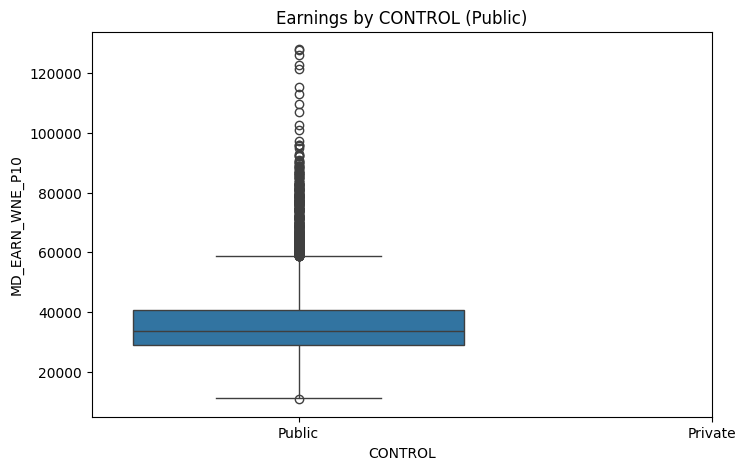

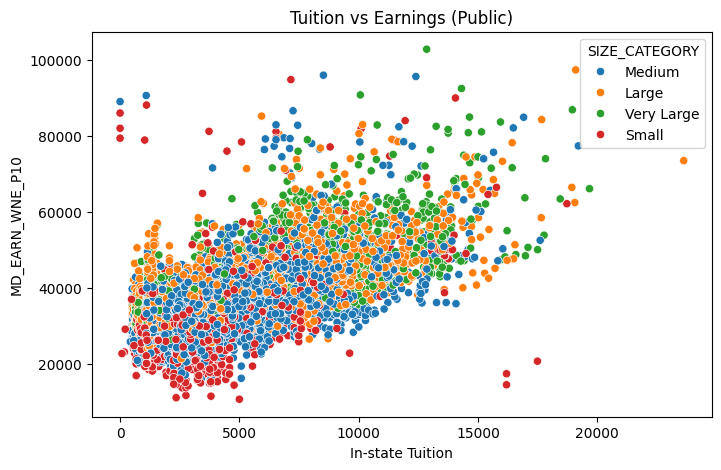

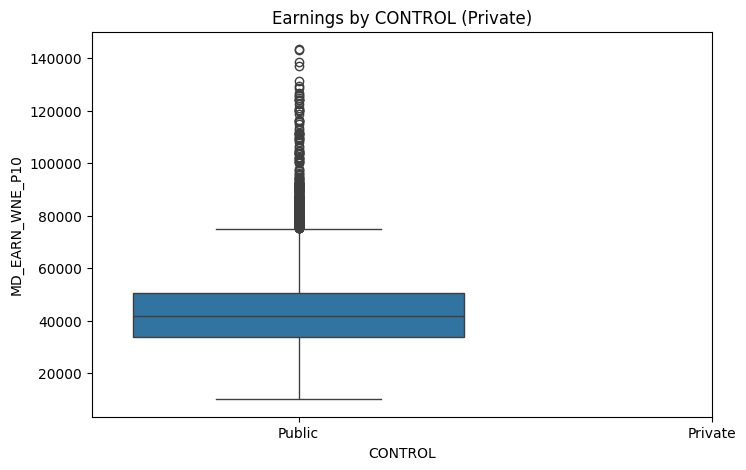

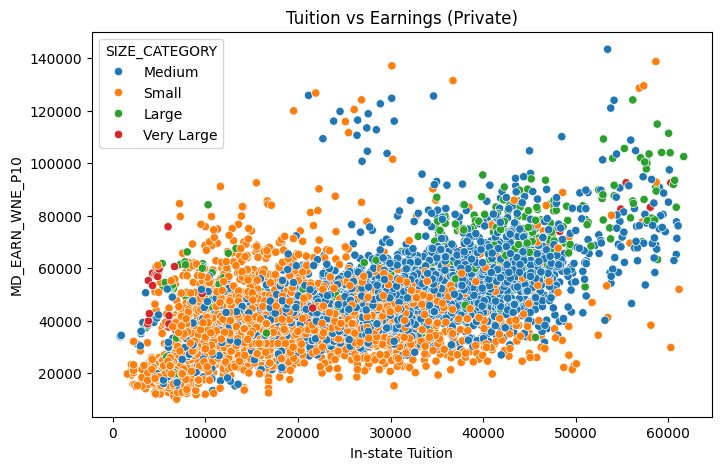

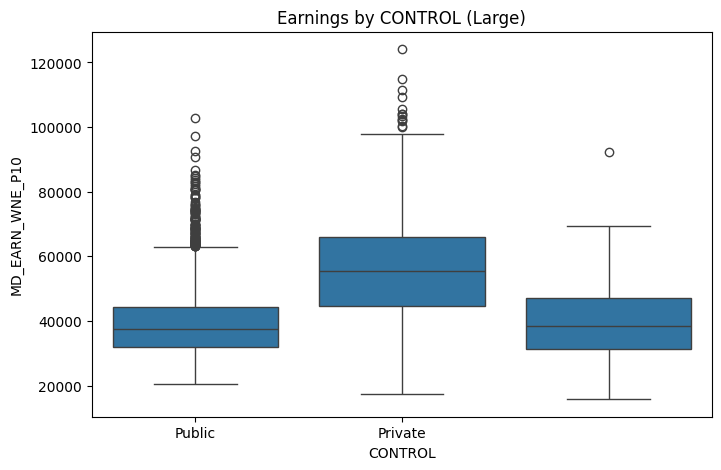

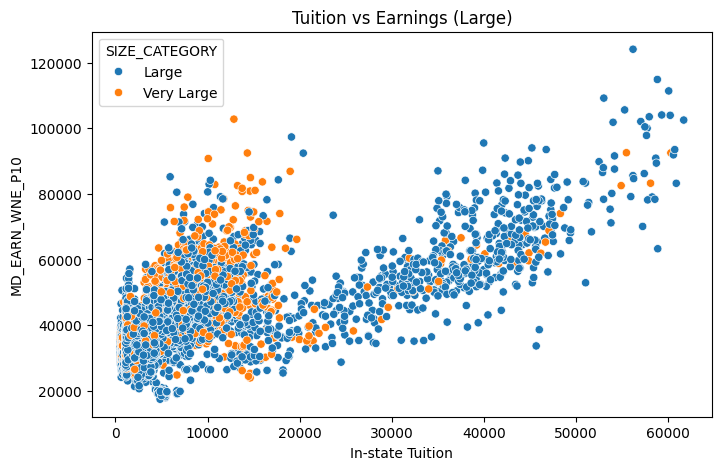

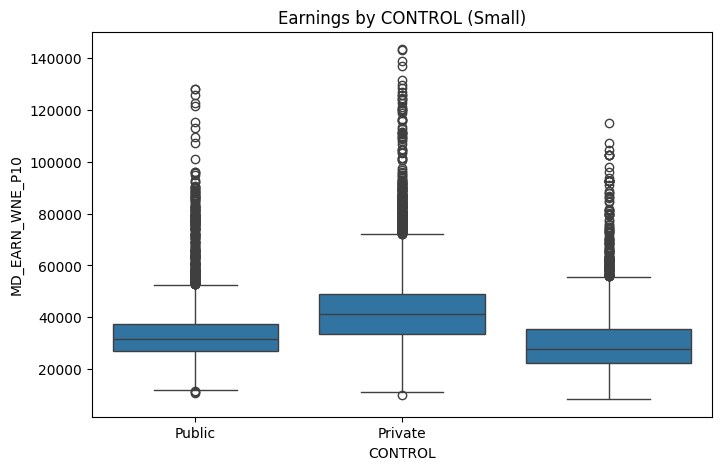

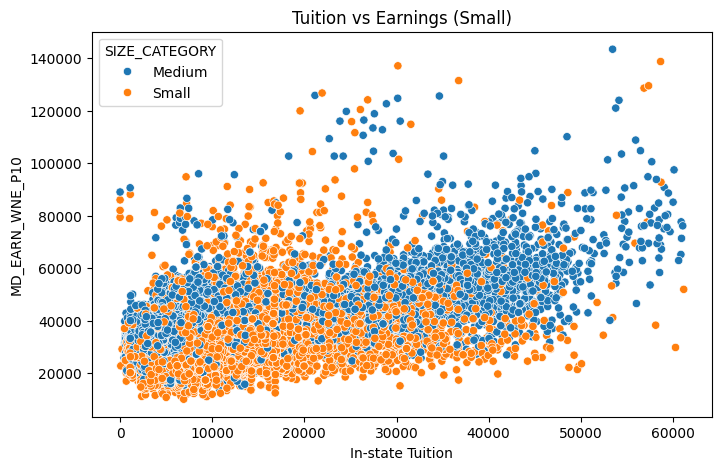

In [34]:
for name, df in plot_subgroups.items():
    plot_trends(df, name)


# Visualization


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load cleaned data
df_viz = pd.read_csv(OUTPUT_PATH + 'ECE143_Project_Cleaned_Data.csv')

print(f"Data loaded: {len(df_viz):,} records")
print(f"Columns: {df_viz.columns.tolist()}")

Data loaded: 133,642 records
Columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'CONTROL', 'ADM_RATE', 'UGDS', 'COSTT4_A', 'TUITIONFEE_IN', 'C150_4', 'MD_EARN_WNE_P10', 'MD_EARN_WNE_P6', 'DEBT_MDN_SUPP', 'GRAD_DEBT_MDN_SUPP', 'YEAR', 'DEBT_TO_EARNINGS', 'ROI_10YR', 'SIZE_CATEGORY', 'SELECTIVITY']


## 1. Exploratory Data Analysis (EDA)

### 1.1 Distribution of Key Outcome Variables

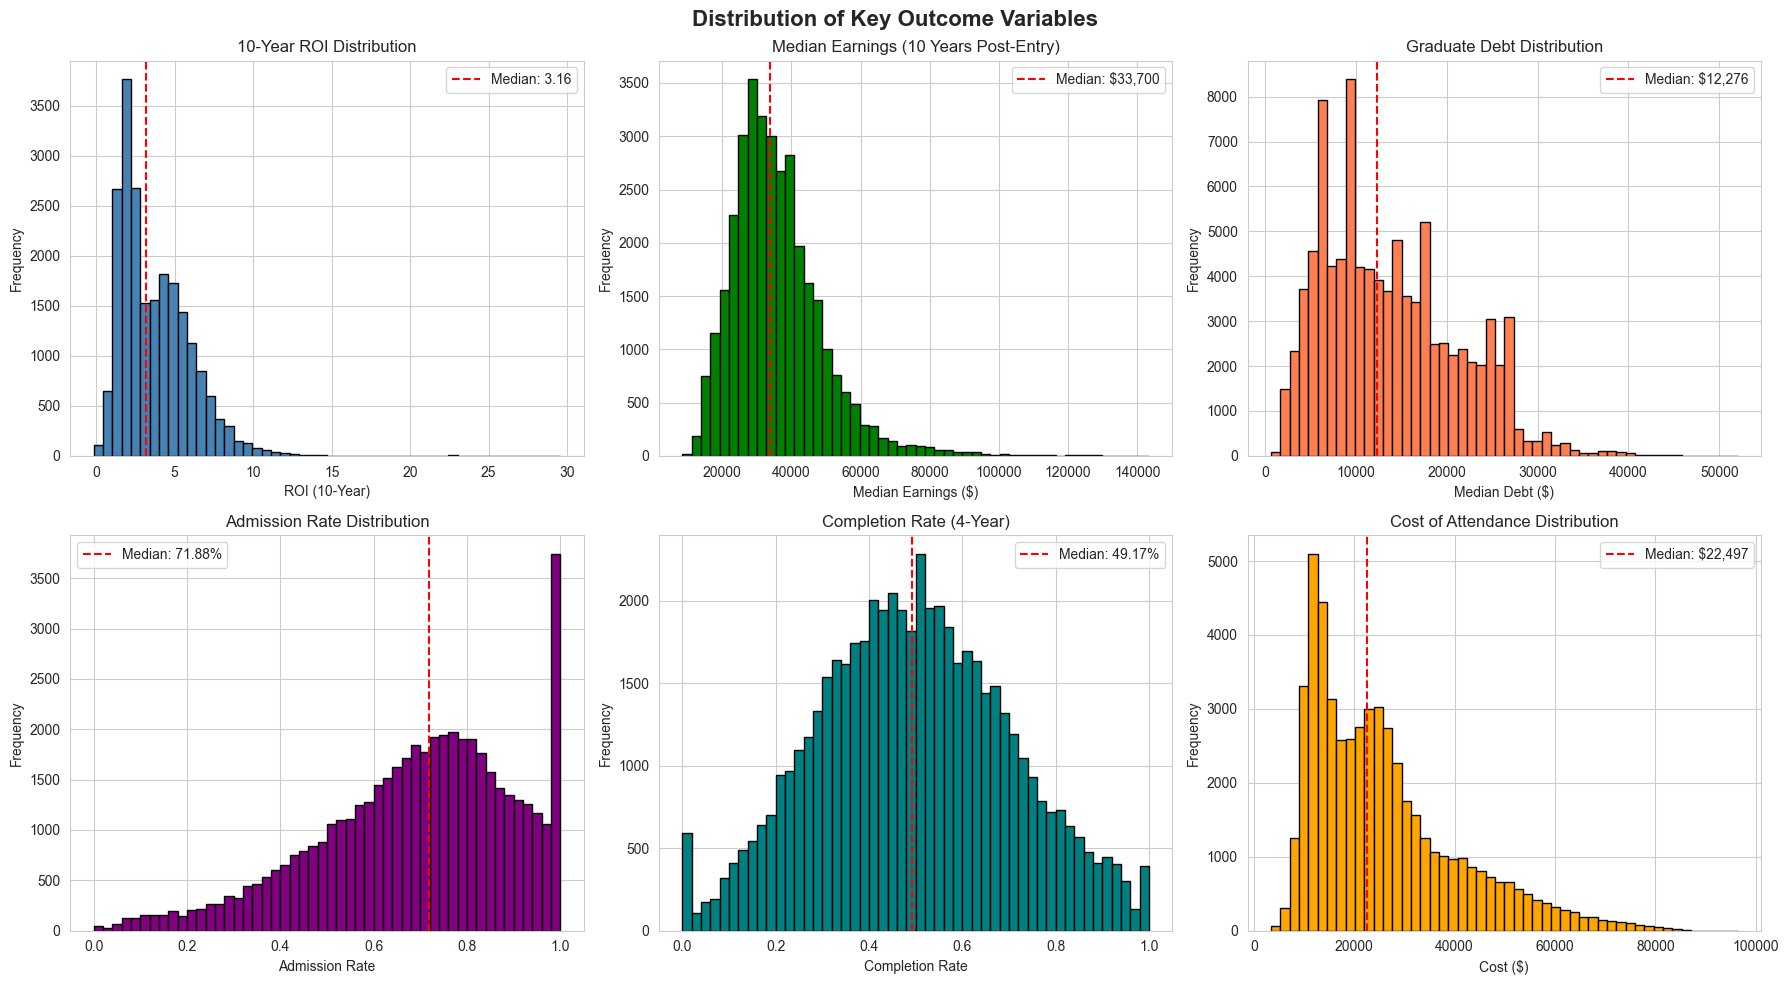


=== Summary Statistics ===
ROI (10-Year): Mean = 3.70, Median = 3.16
Earnings (10-Year): Mean = $35,683, Median = $33,700
Graduate Debt: Mean = $13,757, Median = $12,276
Admission Rate: Mean = 69.19%, Median = 71.88%
Completion Rate: Mean = 49.52%, Median = 49.17%


In [36]:
# Distribution of key outcome variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Outcome Variables', fontsize=16, fontweight='bold')

# 1. ROI Distribution
df_viz['ROI_10YR'].dropna().hist(bins=50, ax=axes[0,0], color='steelblue', edgecolor='black')
axes[0,0].set_title('10-Year ROI Distribution')
axes[0,0].set_xlabel('ROI (10-Year)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df_viz['ROI_10YR'].median(), color='red', linestyle='--', label=f'Median: {df_viz["ROI_10YR"].median():.2f}')
axes[0,0].legend()

# 2. Median Earnings (10-Year)
df_viz['MD_EARN_WNE_P10'].dropna().hist(bins=50, ax=axes[0,1], color='green', edgecolor='black')
axes[0,1].set_title('Median Earnings (10 Years Post-Entry)')
axes[0,1].set_xlabel('Median Earnings ($)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(df_viz['MD_EARN_WNE_P10'].median(), color='red', linestyle='--',
                  label=f'Median: ${df_viz["MD_EARN_WNE_P10"].median():,.0f}')
axes[0,1].legend()

# 3. Graduate Debt
df_viz['GRAD_DEBT_MDN_SUPP'].dropna().hist(bins=50, ax=axes[0,2], color='coral', edgecolor='black')
axes[0,2].set_title('Graduate Debt Distribution')
axes[0,2].set_xlabel('Median Debt ($)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].axvline(df_viz['GRAD_DEBT_MDN_SUPP'].median(), color='red', linestyle='--',
                  label=f'Median: ${df_viz["GRAD_DEBT_MDN_SUPP"].median():,.0f}')
axes[0,2].legend()

# 4. Admission Rate
df_viz['ADM_RATE'].dropna().hist(bins=50, ax=axes[1,0], color='purple', edgecolor='black')
axes[1,0].set_title('Admission Rate Distribution')
axes[1,0].set_xlabel('Admission Rate')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(df_viz['ADM_RATE'].median(), color='red', linestyle='--',
                  label=f'Median: {df_viz["ADM_RATE"].median():.2%}')
axes[1,0].legend()

# 5. Completion Rate
df_viz['C150_4'].dropna().hist(bins=50, ax=axes[1,1], color='teal', edgecolor='black')
axes[1,1].set_title('Completion Rate (4-Year)')
axes[1,1].set_xlabel('Completion Rate')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(df_viz['C150_4'].median(), color='red', linestyle='--',
                  label=f'Median: {df_viz["C150_4"].median():.2%}')
axes[1,1].legend()

# 6. Cost of Attendance
df_viz['COSTT4_A'].dropna().hist(bins=50, ax=axes[1,2], color='orange', edgecolor='black')
axes[1,2].set_title('Cost of Attendance Distribution')
axes[1,2].set_xlabel('Cost ($)')
axes[1,2].set_ylabel('Frequency')
axes[1,2].axvline(df_viz['COSTT4_A'].median(), color='red', linestyle='--',
                  label=f'Median: ${df_viz["COSTT4_A"].median():,.0f}')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"ROI (10-Year): Mean = {df_viz['ROI_10YR'].mean():.2f}, Median = {df_viz['ROI_10YR'].median():.2f}")
print(f"Earnings (10-Year): Mean = ${df_viz['MD_EARN_WNE_P10'].mean():,.0f}, Median = ${df_viz['MD_EARN_WNE_P10'].median():,.0f}")
print(f"Graduate Debt: Mean = ${df_viz['GRAD_DEBT_MDN_SUPP'].mean():,.0f}, Median = ${df_viz['GRAD_DEBT_MDN_SUPP'].median():,.0f}")
print(f"Admission Rate: Mean = {df_viz['ADM_RATE'].mean():.2%}, Median = {df_viz['ADM_RATE'].median():.2%}")
print(f"Completion Rate: Mean = {df_viz['C150_4'].mean():.2%}, Median = {df_viz['C150_4'].median():.2%}")

### 1.2 Comparison by Institution Type (Public vs Private)

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2532166647.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_roi, x='CONTROL_TYPE', y='ROI_10YR', ax=axes[0,0], palette='Set2')
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2532166647.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_earn, x='CONTROL_TYPE', y='MD_EARN_WNE_P10', ax=axes[0,1], palette='Set2')
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2532166647.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(da

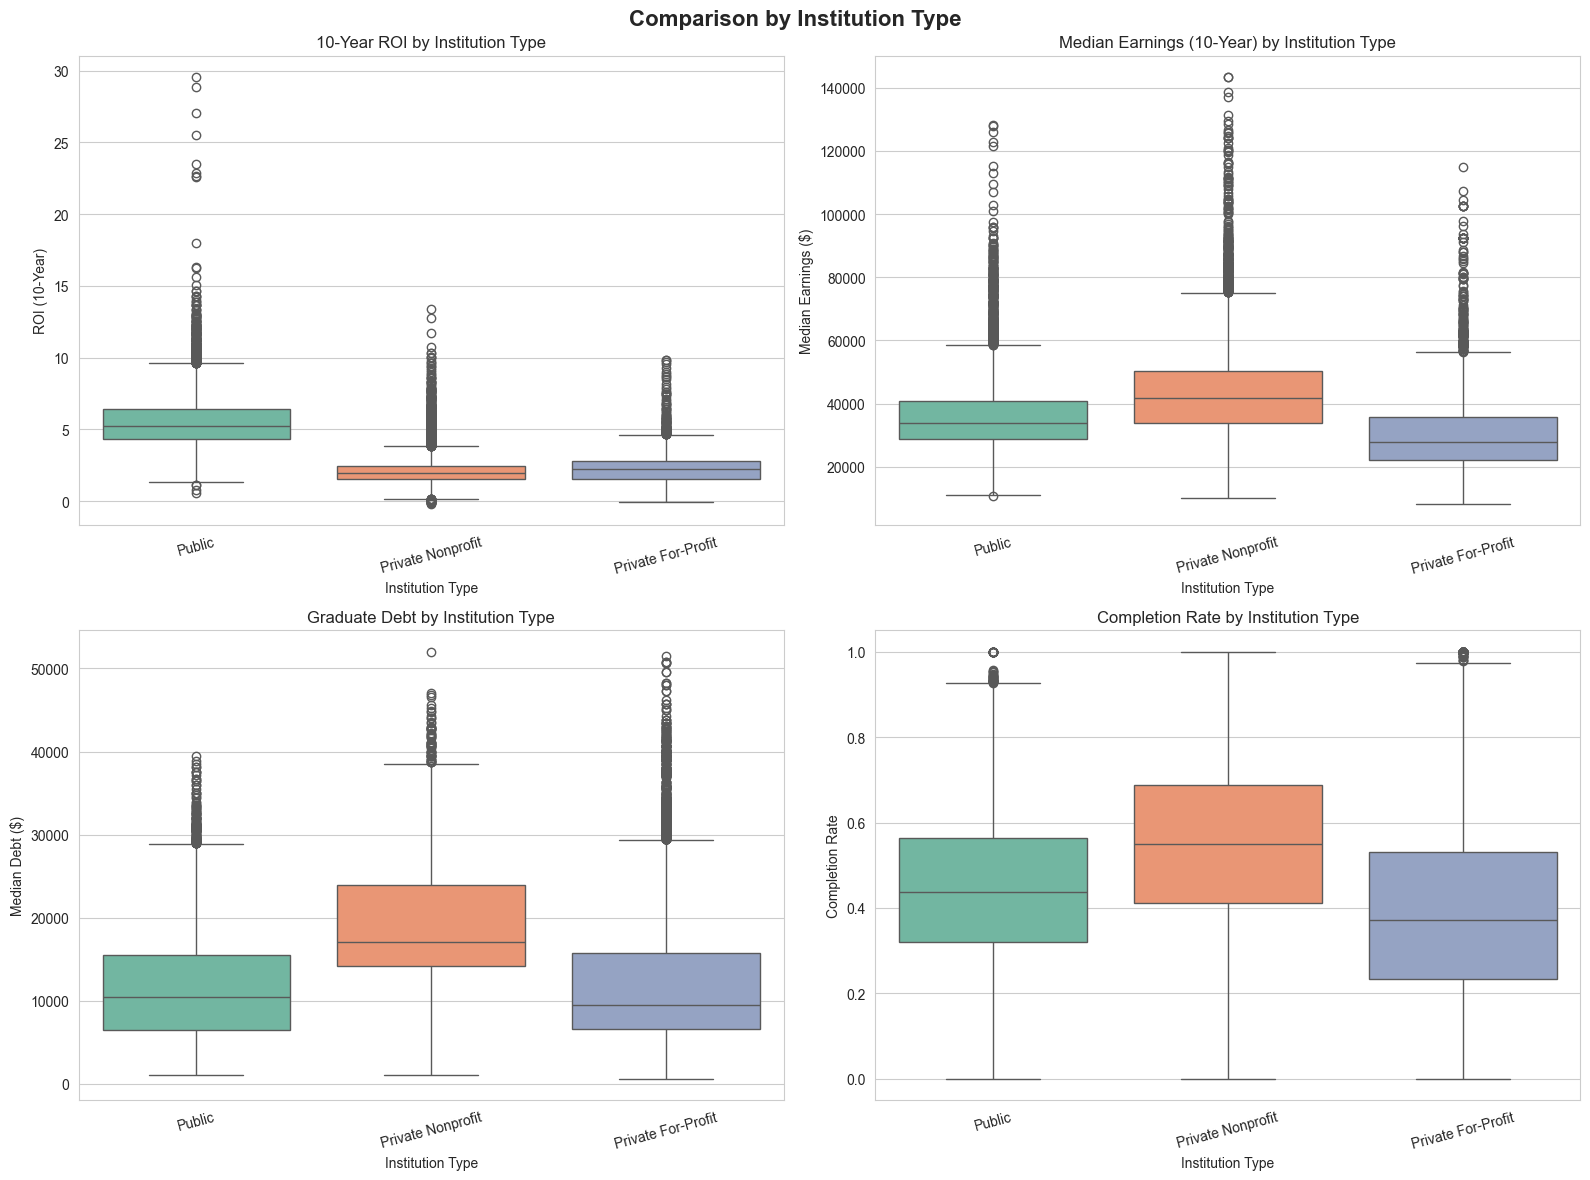


=== Comparison by Institution Type ===

Public:
  Count: 50,309
  Avg ROI: 5.56
  Avg Earnings: $35,947
  Avg Debt: $11,654
  Avg Completion Rate: 45.04%

Private Nonprofit:
  Count: 37,808
  Avg ROI: 2.20
  Avg Earnings: $43,235
  Avg Debt: $18,244
  Avg Completion Rate: 54.72%

Private For-Profit:
  Count: 45,525
  Avg ROI: 2.34
  Avg Earnings: $29,825
  Avg Debt: $12,127
  Avg Completion Rate: 39.05%


In [37]:
# Compare outcomes by institution type
# Create control type labels
control_map = {1.0: 'Public', 2.0: 'Private Nonprofit', 3.0: 'Private For-Profit'}
df_viz['CONTROL_TYPE'] = df_viz['CONTROL'].map(control_map)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison by Institution Type', fontsize=16, fontweight='bold')

# 1. ROI by Type
df_roi = df_viz[df_viz['ROI_10YR'].notna()]
sns.boxplot(data=df_roi, x='CONTROL_TYPE', y='ROI_10YR', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('10-Year ROI by Institution Type')
axes[0,0].set_xlabel('Institution Type')
axes[0,0].set_ylabel('ROI (10-Year)')
axes[0,0].tick_params(axis='x', rotation=15)

# 2. Median Earnings by Type
df_earn = df_viz[df_viz['MD_EARN_WNE_P10'].notna()]
sns.boxplot(data=df_earn, x='CONTROL_TYPE', y='MD_EARN_WNE_P10', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Median Earnings (10-Year) by Institution Type')
axes[0,1].set_xlabel('Institution Type')
axes[0,1].set_ylabel('Median Earnings ($)')
axes[0,1].tick_params(axis='x', rotation=15)

# 3. Graduate Debt by Type
df_debt = df_viz[df_viz['GRAD_DEBT_MDN_SUPP'].notna()]
sns.boxplot(data=df_debt, x='CONTROL_TYPE', y='GRAD_DEBT_MDN_SUPP', ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Graduate Debt by Institution Type')
axes[1,0].set_xlabel('Institution Type')
axes[1,0].set_ylabel('Median Debt ($)')
axes[1,0].tick_params(axis='x', rotation=15)

# 4. Completion Rate by Type
df_comp = df_viz[df_viz['C150_4'].notna()]
sns.boxplot(data=df_comp, x='CONTROL_TYPE', y='C150_4', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Completion Rate by Institution Type')
axes[1,1].set_xlabel('Institution Type')
axes[1,1].set_ylabel('Completion Rate')
axes[1,1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Print comparative statistics
print("\n=== Comparison by Institution Type ===")
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_viz[df_viz['CONTROL_TYPE'] == control_type]
    print(f"\n{control_type}:")
    print(f"  Count: {len(df_type):,}")
    print(f"  Avg ROI: {df_type['ROI_10YR'].mean():.2f}")
    print(f"  Avg Earnings: ${df_type['MD_EARN_WNE_P10'].mean():,.0f}")
    print(f"  Avg Debt: ${df_type['GRAD_DEBT_MDN_SUPP'].mean():,.0f}")
    print(f"  Avg Completion Rate: {df_type['C150_4'].mean():.2%}")

### 1.3 Correlation Analysis

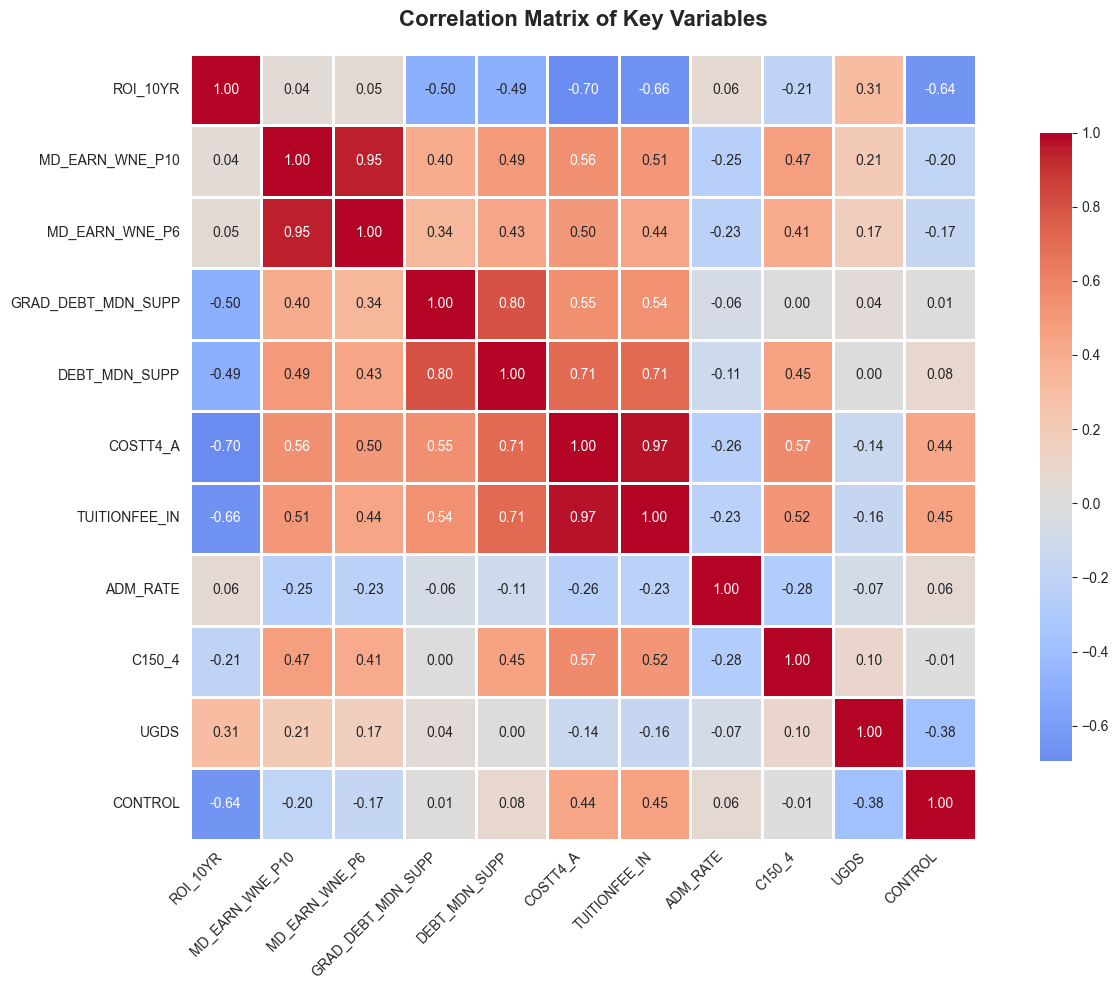


=== Strongest Correlations with ROI ===
UGDS                  0.309023
ADM_RATE              0.062023
MD_EARN_WNE_P6        0.049229
MD_EARN_WNE_P10       0.042048
C150_4               -0.205821
DEBT_MDN_SUPP        -0.494077
GRAD_DEBT_MDN_SUPP   -0.503699
CONTROL              -0.643896
TUITIONFEE_IN        -0.657126
COSTT4_A             -0.696076
Name: ROI_10YR, dtype: float64

=== Strongest Correlations with Median Earnings (10-Year) ===
MD_EARN_WNE_P6        0.945767
COSTT4_A              0.555698
TUITIONFEE_IN         0.509796
DEBT_MDN_SUPP         0.493482
C150_4                0.470979
GRAD_DEBT_MDN_SUPP    0.399470
UGDS                  0.209014
ROI_10YR              0.042048
CONTROL              -0.197337
ADM_RATE             -0.252607
Name: MD_EARN_WNE_P10, dtype: float64


In [38]:
# Correlation heatmap of key variables
key_vars = ['ROI_10YR', 'MD_EARN_WNE_P10', 'MD_EARN_WNE_P6', 'GRAD_DEBT_MDN_SUPP',
            'DEBT_MDN_SUPP', 'COSTT4_A', 'TUITIONFEE_IN', 'ADM_RATE', 'C150_4', 'UGDS', 'CONTROL']

df_corr = df_viz[key_vars].copy()
correlation_matrix = df_corr.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify strongest correlations
print("\n=== Strongest Correlations with ROI ===")
roi_corr = correlation_matrix['ROI_10YR'].drop('ROI_10YR').sort_values(ascending=False)
print(roi_corr)

print("\n=== Strongest Correlations with Median Earnings (10-Year) ===")
earn_corr = correlation_matrix['MD_EARN_WNE_P10'].drop('MD_EARN_WNE_P10').sort_values(ascending=False)
print(earn_corr)

### 1.4 Key Relationships: Scatter Plots

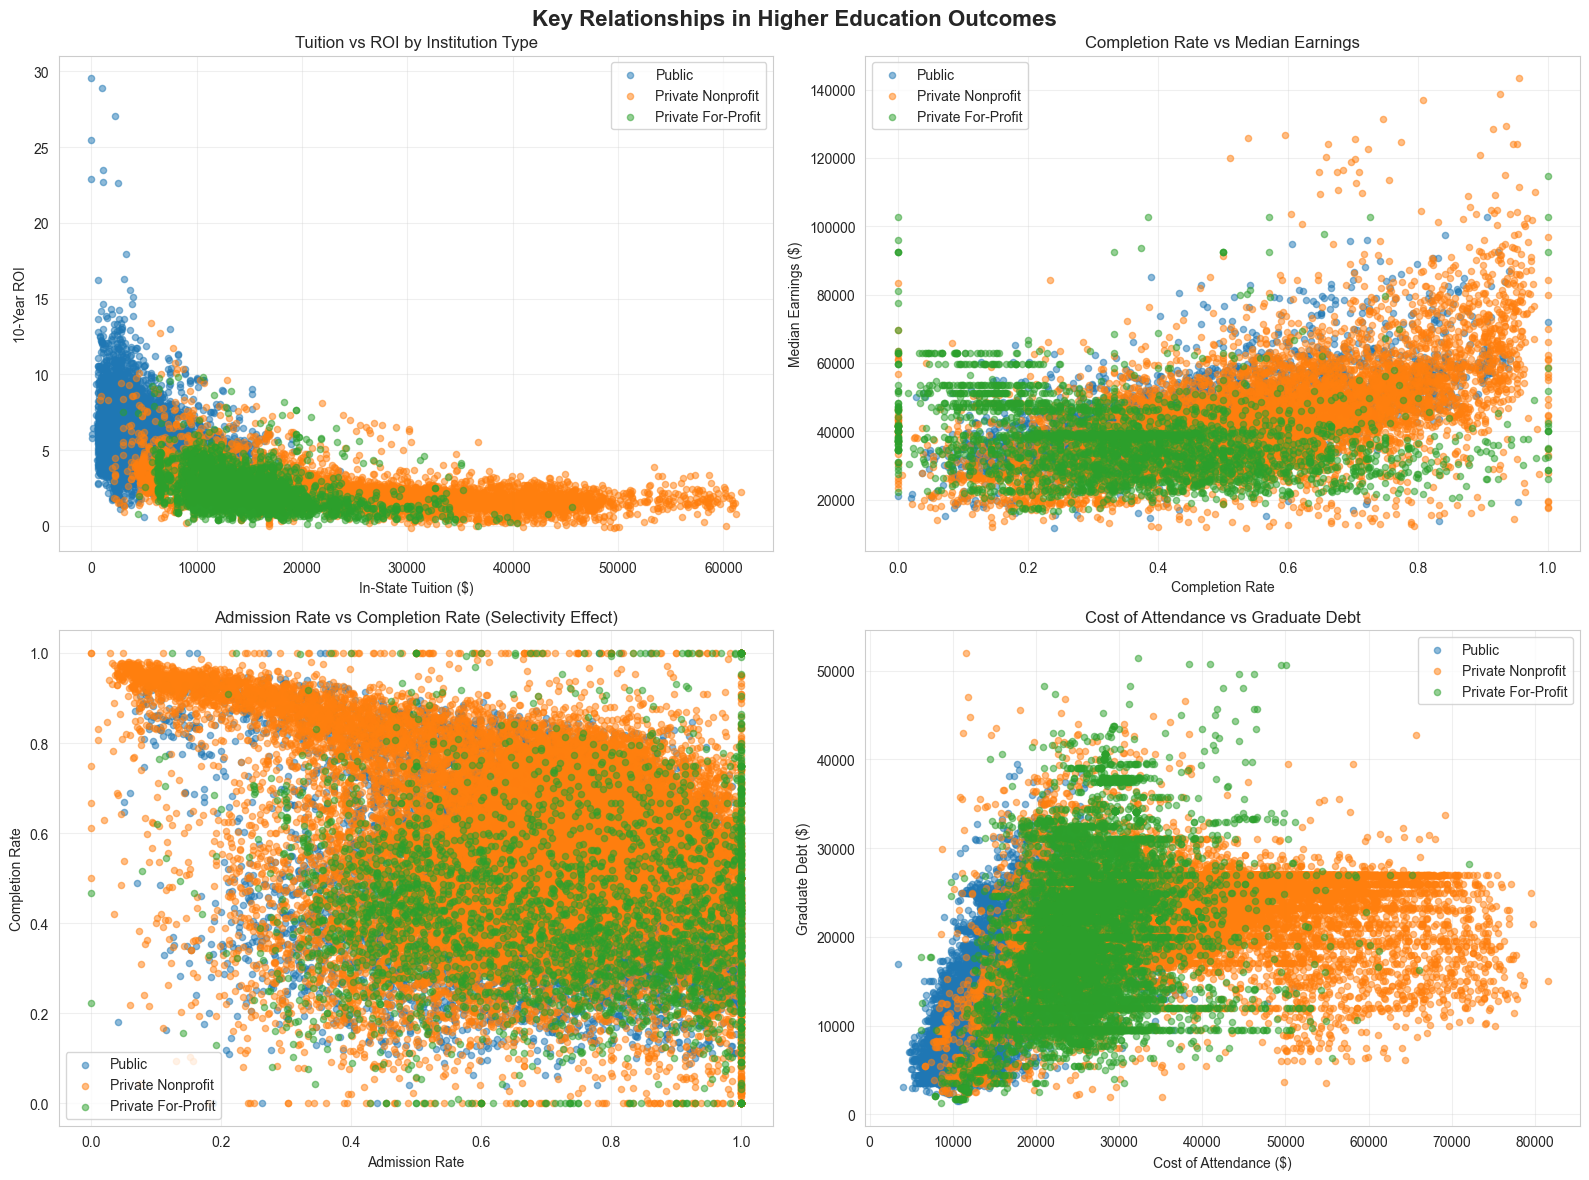

In [39]:
# Scatter plots showing key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Relationships in Higher Education Outcomes', fontsize=16, fontweight='bold')

# 1. Tuition vs ROI (colored by institution type)
df_plot1 = df_viz[df_viz['TUITIONFEE_IN'].notna() & df_viz['ROI_10YR'].notna()]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_plot1[df_plot1['CONTROL_TYPE'] == control_type]
    axes[0,0].scatter(df_type['TUITIONFEE_IN'], df_type['ROI_10YR'],
                      alpha=0.5, label=control_type, s=20)
axes[0,0].set_xlabel('In-State Tuition ($)')
axes[0,0].set_ylabel('10-Year ROI')
axes[0,0].set_title('Tuition vs ROI by Institution Type')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Completion Rate vs Median Earnings
df_plot2 = df_viz[df_viz['C150_4'].notna() & df_viz['MD_EARN_WNE_P10'].notna()]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_plot2[df_plot2['CONTROL_TYPE'] == control_type]
    axes[0,1].scatter(df_type['C150_4'], df_type['MD_EARN_WNE_P10'],
                      alpha=0.5, label=control_type, s=20)
axes[0,1].set_xlabel('Completion Rate')
axes[0,1].set_ylabel('Median Earnings ($)')
axes[0,1].set_title('Completion Rate vs Median Earnings')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Admission Rate vs Completion Rate
df_plot3 = df_viz[df_viz['ADM_RATE'].notna() & df_viz['C150_4'].notna()]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_plot3[df_plot3['CONTROL_TYPE'] == control_type]
    axes[1,0].scatter(df_type['ADM_RATE'], df_type['C150_4'],
                      alpha=0.5, label=control_type, s=20)
axes[1,0].set_xlabel('Admission Rate')
axes[1,0].set_ylabel('Completion Rate')
axes[1,0].set_title('Admission Rate vs Completion Rate (Selectivity Effect)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Cost vs Debt
df_plot4 = df_viz[df_viz['COSTT4_A'].notna() & df_viz['GRAD_DEBT_MDN_SUPP'].notna()]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_plot4[df_plot4['CONTROL_TYPE'] == control_type]
    axes[1,1].scatter(df_type['COSTT4_A'], df_type['GRAD_DEBT_MDN_SUPP'],
                      alpha=0.5, label=control_type, s=20)
axes[1,1].set_xlabel('Cost of Attendance ($)')
axes[1,1].set_ylabel('Graduate Debt ($)')
axes[1,1].set_title('Cost of Attendance vs Graduate Debt')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.5 Trends Over Time

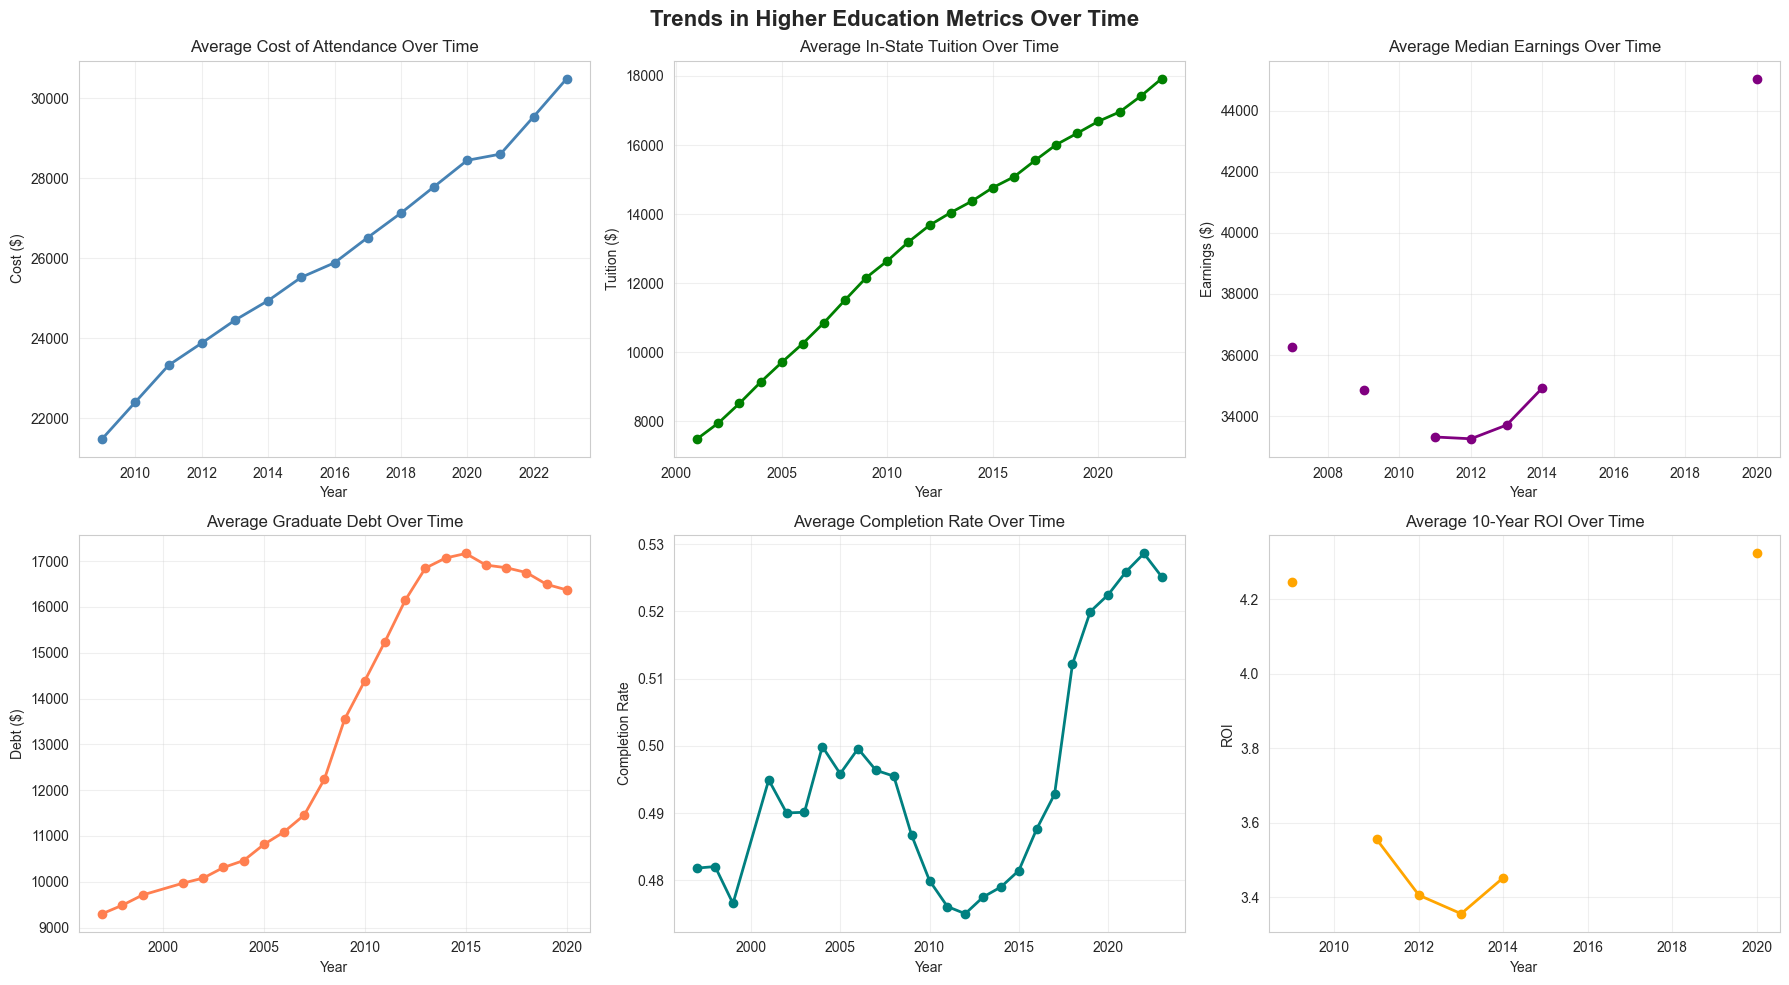


=== Key Trends ===
Cost increase: $nan (1996) → $30,491 (2023)
Earnings increase: $nan → $nan
Debt increase: $nan → $nan


In [40]:
# Trends over time
# Extract year from YEAR column (format: YYYY_YY)
df_viz['YEAR_INT'] = df_viz['YEAR'].str[:4].astype(int)

# Calculate yearly averages
yearly_stats = df_viz.groupby('YEAR_INT').agg({
    'COSTT4_A': 'mean',
    'TUITIONFEE_IN': 'mean',
    'MD_EARN_WNE_P10': 'mean',
    'GRAD_DEBT_MDN_SUPP': 'mean',
    'C150_4': 'mean',
    'ROI_10YR': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Trends in Higher Education Metrics Over Time', fontsize=16, fontweight='bold')

# 1. Cost Trend
axes[0,0].plot(yearly_stats['YEAR_INT'], yearly_stats['COSTT4_A'],
               marker='o', linewidth=2, color='steelblue')
axes[0,0].set_title('Average Cost of Attendance Over Time')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Cost ($)')
axes[0,0].grid(True, alpha=0.3)

# 2. Tuition Trend
axes[0,1].plot(yearly_stats['YEAR_INT'], yearly_stats['TUITIONFEE_IN'],
               marker='o', linewidth=2, color='green')
axes[0,1].set_title('Average In-State Tuition Over Time')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Tuition ($)')
axes[0,1].grid(True, alpha=0.3)

# 3. Earnings Trend
axes[0,2].plot(yearly_stats['YEAR_INT'], yearly_stats['MD_EARN_WNE_P10'],
               marker='o', linewidth=2, color='purple')
axes[0,2].set_title('Average Median Earnings Over Time')
axes[0,2].set_xlabel('Year')
axes[0,2].set_ylabel('Earnings ($)')
axes[0,2].grid(True, alpha=0.3)

# 4. Debt Trend
axes[1,0].plot(yearly_stats['YEAR_INT'], yearly_stats['GRAD_DEBT_MDN_SUPP'],
               marker='o', linewidth=2, color='coral')
axes[1,0].set_title('Average Graduate Debt Over Time')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Debt ($)')
axes[1,0].grid(True, alpha=0.3)

# 5. Completion Rate Trend
axes[1,1].plot(yearly_stats['YEAR_INT'], yearly_stats['C150_4'],
               marker='o', linewidth=2, color='teal')
axes[1,1].set_title('Average Completion Rate Over Time')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Completion Rate')
axes[1,1].grid(True, alpha=0.3)

# 6. ROI Trend
axes[1,2].plot(yearly_stats['YEAR_INT'], yearly_stats['ROI_10YR'],
               marker='o', linewidth=2, color='orange')
axes[1,2].set_title('Average 10-Year ROI Over Time')
axes[1,2].set_xlabel('Year')
axes[1,2].set_ylabel('ROI')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Key Trends ===")
print(f"Cost increase: ${yearly_stats['COSTT4_A'].iloc[0]:,.0f} (1996) → ${yearly_stats['COSTT4_A'].iloc[-1]:,.0f} (2023)")
print(f"Earnings increase: ${yearly_stats['MD_EARN_WNE_P10'].iloc[0]:,.0f} → ${yearly_stats['MD_EARN_WNE_P10'].iloc[-1]:,.0f}")
print(f"Debt increase: ${yearly_stats['GRAD_DEBT_MDN_SUPP'].iloc[0]:,.0f} → ${yearly_stats['GRAD_DEBT_MDN_SUPP'].iloc[-1]:,.0f}")

## 2. Model Performance Visualization

### 2.1 Random Forest: Feature Importance

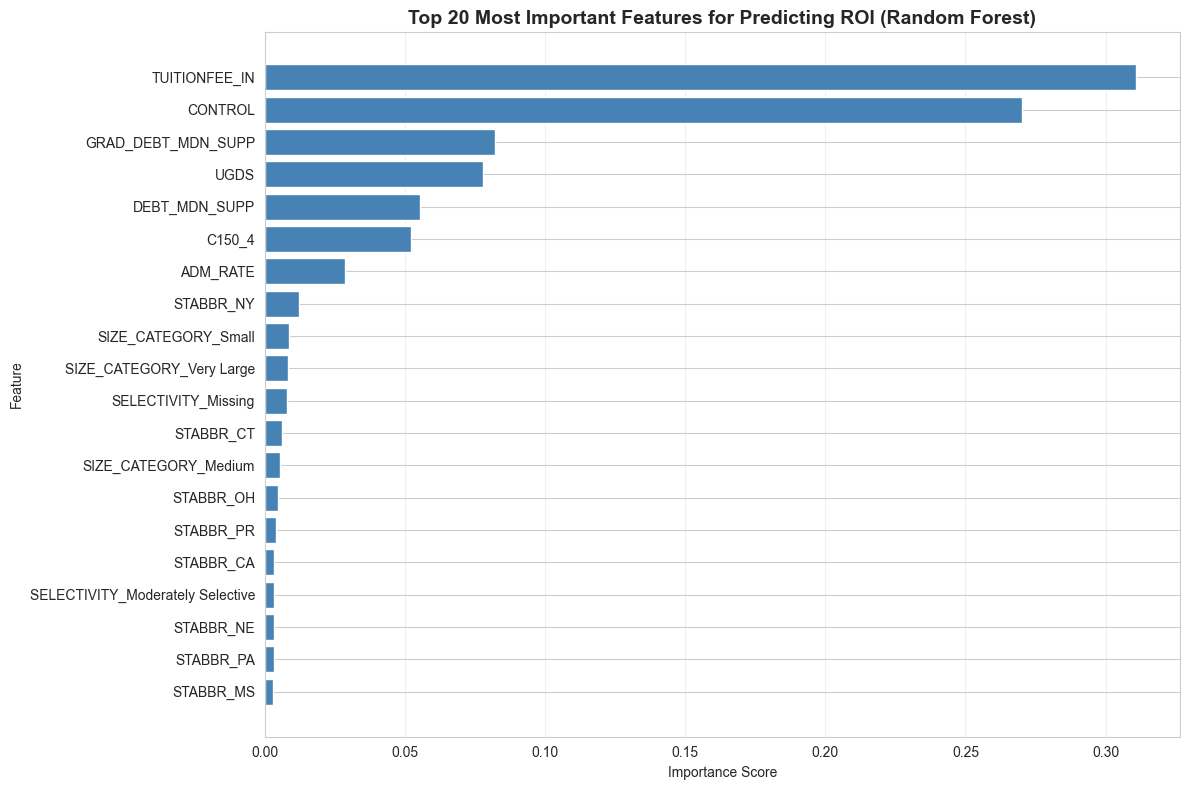


=== Top 10 Features (with percentage contribution) ===
TUITIONFEE_IN                 : 0.3110 (31.10%)
CONTROL                       : 0.2702 (27.02%)
GRAD_DEBT_MDN_SUPP            : 0.0822 (8.22%)
UGDS                          : 0.0777 (7.77%)
DEBT_MDN_SUPP                 : 0.0553 (5.53%)
C150_4                        : 0.0522 (5.22%)
ADM_RATE                      : 0.0287 (2.87%)
STABBR_NY                     : 0.0123 (1.23%)
SIZE_CATEGORY_Small           : 0.0085 (0.85%)
SIZE_CATEGORY_Very Large      : 0.0084 (0.84%)


In [41]:
# Feature Importance from Random Forest Model
# Note: Using the feature importances from the trained model above

# Get feature importances from the trained model
importances = rf_final.feature_importances_
feature_names = X_train.columns

# Create DataFrame for easier manipulation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
top_n = 20
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), feature_importance_df['Importance'].head(top_n), color='steelblue')
plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n))
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features for Predicting ROI (Random Forest)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 10 with percentages
print("\n=== Top 10 Features (with percentage contribution) ===")
total_importance = feature_importance_df['Importance'].sum()
for i, row in feature_importance_df.head(10).iterrows():
    percentage = (row['Importance'] / total_importance) * 100
    print(f"{row['Feature']:30s}: {row['Importance']:.4f} ({percentage:.2f}%)")

### 2.2 Model Prediction Performance

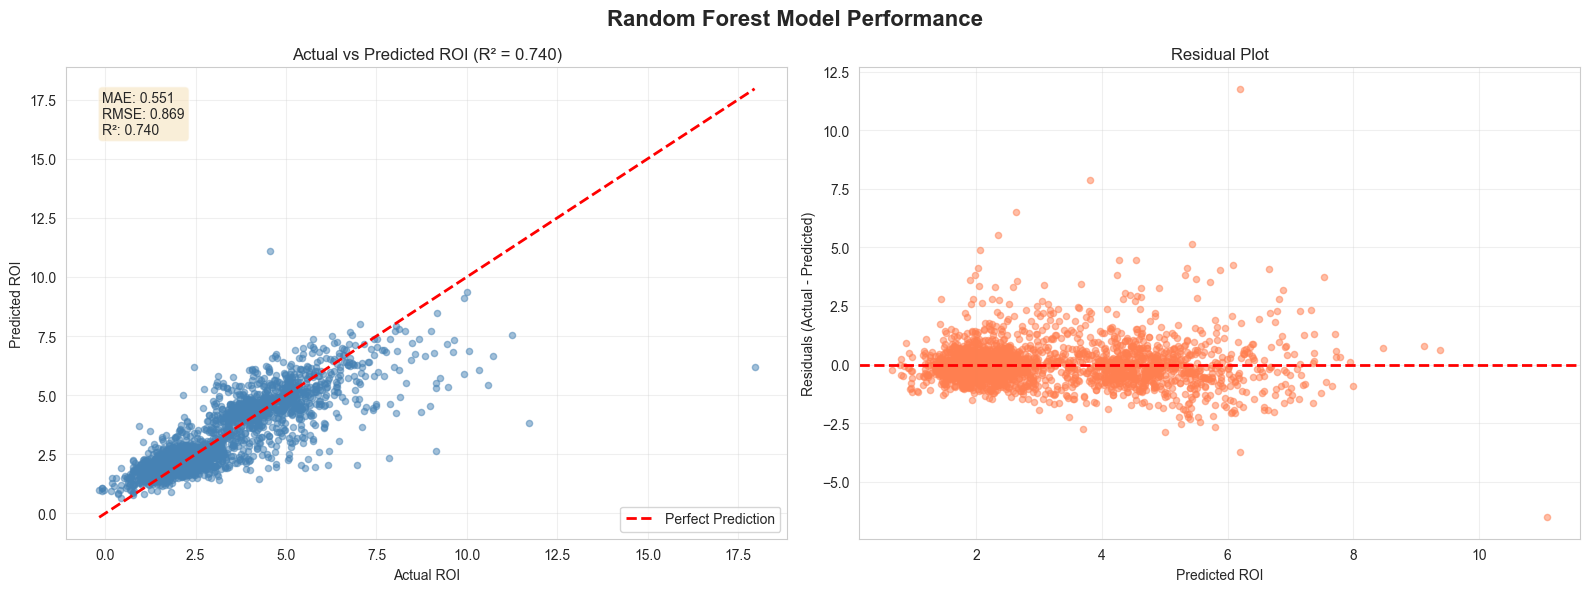

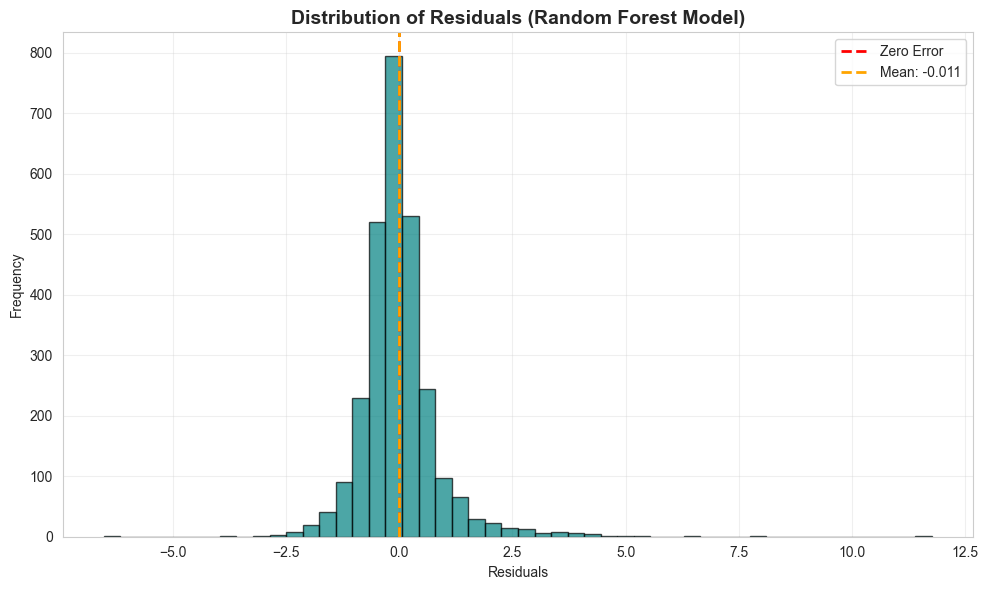


=== Residual Statistics ===
Mean Residual: -0.0109
Std Residual: 0.8692
Min Residual: -6.5207
Max Residual: 11.7645


In [42]:
# Actual vs Predicted values from Random Forest model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Forest Model Performance', fontsize=16, fontweight='bold')

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.5, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual ROI')
axes[0].set_ylabel('Predicted ROI')
axes[0].set_title(f'Actual vs Predicted ROI (R² = {r2_score(y_test, y_pred):.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add text with metrics
mae_val = mean_absolute_error(y_test, y_pred)
rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
r2_val = r2_score(y_test, y_pred)
textstr = f'MAE: {mae_val:.3f}\nRMSE: {rmse_val:.3f}\nR²: {r2_val:.3f}'
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=20, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted ROI')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Random Forest Model)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.axvline(x=residuals.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {residuals.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n=== Residual Statistics ===")
print(f"Mean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")
print(f"Min Residual: {residuals.min():.4f}")
print(f"Max Residual: {residuals.max():.4f}")

## 3. Comparative Analysis & Key Insights

### 3.1 Geographic Analysis: Top States

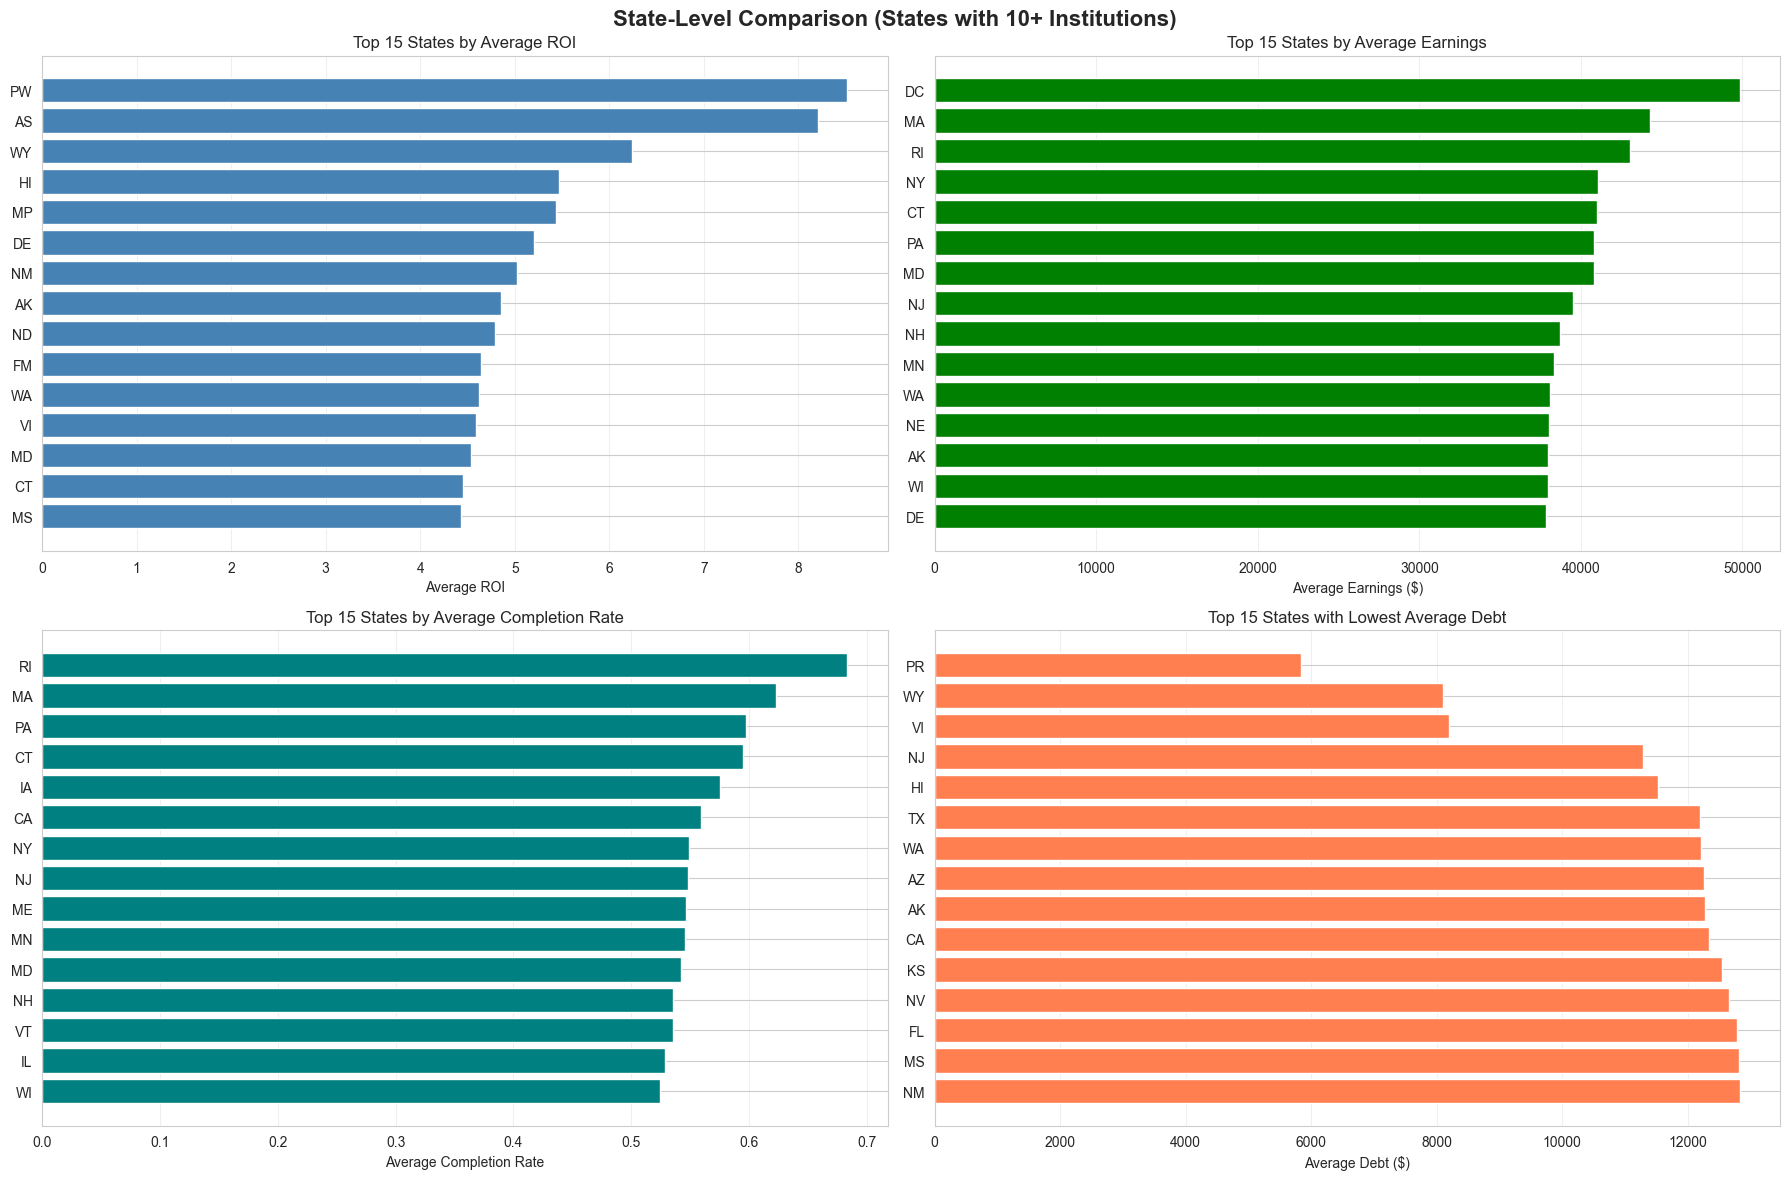


=== Top 5 States by ROI ===
   State   Avg_ROI  Avg_Earnings  Num_Institutions
45    PW  8.518598  24919.600000                27
3     AS  8.209000  21912.428571                27
58    WY  6.242473  35297.718750               245
14    HI  5.473232  36618.761905               507
29    MP  5.437078  20848.000000                27


In [43]:
# Geographic analysis - comparing states
state_stats = df_viz.groupby('STABBR').agg({
    'ROI_10YR': 'mean',
    'MD_EARN_WNE_P10': 'mean',
    'GRAD_DEBT_MDN_SUPP': 'mean',
    'C150_4': 'mean',
    'UNITID': 'count'  # Number of institutions
}).reset_index()
state_stats.columns = ['State', 'Avg_ROI', 'Avg_Earnings', 'Avg_Debt', 'Avg_Completion', 'Num_Institutions']

# Filter states with at least 10 institutions for meaningful comparison
state_stats = state_stats[state_stats['Num_Institutions'] >= 10]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('State-Level Comparison (States with 10+ Institutions)', fontsize=16, fontweight='bold')

# 1. Top 15 states by ROI
top_roi_states = state_stats.nlargest(15, 'Avg_ROI')
axes[0,0].barh(range(len(top_roi_states)), top_roi_states['Avg_ROI'], color='steelblue')
axes[0,0].set_yticks(range(len(top_roi_states)))
axes[0,0].set_yticklabels(top_roi_states['State'])
axes[0,0].set_xlabel('Average ROI')
axes[0,0].set_title('Top 15 States by Average ROI')
axes[0,0].invert_yaxis()
axes[0,0].grid(axis='x', alpha=0.3)

# 2. Top 15 states by Earnings
top_earn_states = state_stats.nlargest(15, 'Avg_Earnings')
axes[0,1].barh(range(len(top_earn_states)), top_earn_states['Avg_Earnings'], color='green')
axes[0,1].set_yticks(range(len(top_earn_states)))
axes[0,1].set_yticklabels(top_earn_states['State'])
axes[0,1].set_xlabel('Average Earnings ($)')
axes[0,1].set_title('Top 15 States by Average Earnings')
axes[0,1].invert_yaxis()
axes[0,1].grid(axis='x', alpha=0.3)

# 3. Top 15 states by Completion Rate
top_comp_states = state_stats.nlargest(15, 'Avg_Completion')
axes[1,0].barh(range(len(top_comp_states)), top_comp_states['Avg_Completion'], color='teal')
axes[1,0].set_yticks(range(len(top_comp_states)))
axes[1,0].set_yticklabels(top_comp_states['State'])
axes[1,0].set_xlabel('Average Completion Rate')
axes[1,0].set_title('Top 15 States by Average Completion Rate')
axes[1,0].invert_yaxis()
axes[1,0].grid(axis='x', alpha=0.3)

# 4. States with lowest debt
lowest_debt_states = state_stats.nsmallest(15, 'Avg_Debt')
axes[1,1].barh(range(len(lowest_debt_states)), lowest_debt_states['Avg_Debt'], color='coral')
axes[1,1].set_yticks(range(len(lowest_debt_states)))
axes[1,1].set_yticklabels(lowest_debt_states['State'])
axes[1,1].set_xlabel('Average Debt ($)')
axes[1,1].set_title('Top 15 States with Lowest Average Debt')
axes[1,1].invert_yaxis()
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Top 5 States by ROI ===")
print(top_roi_states[['State', 'Avg_ROI', 'Avg_Earnings', 'Num_Institutions']].head())

### 3.2 Top Performing Institutions

=== Top 20 Institutions by ROI (Most Recent Year) ===
                                                     INSTNM STABBR CONTROL_TYPE  ROI_10YR  MD_EARN_WNE_P10  COSTT4_A  GRAD_DEBT_MDN_SUPP
                      United States Merchant Marine Academy     NY       Public 22.682697          90610.0    9547.0              8833.0
                  George T Baker Aviation Technical College     FL       Public 22.611437          52312.0    4267.0                 NaN
   Instituto Tecnologico de Puerto Rico-Recinto de San Juan     PR       Public 15.590737          26293.0    4274.0                 NaN
      Instituto Tecnologico de Puerto Rico-Recinto de Ponce     PR       Public 14.609713          26293.0    4211.0                 NaN
                                Cleveland Community College     NC       Public 14.265467          33755.0    5477.0                 NaN
                                       College of San Mateo     CA       Public 13.854667          54172.0   11875.0        

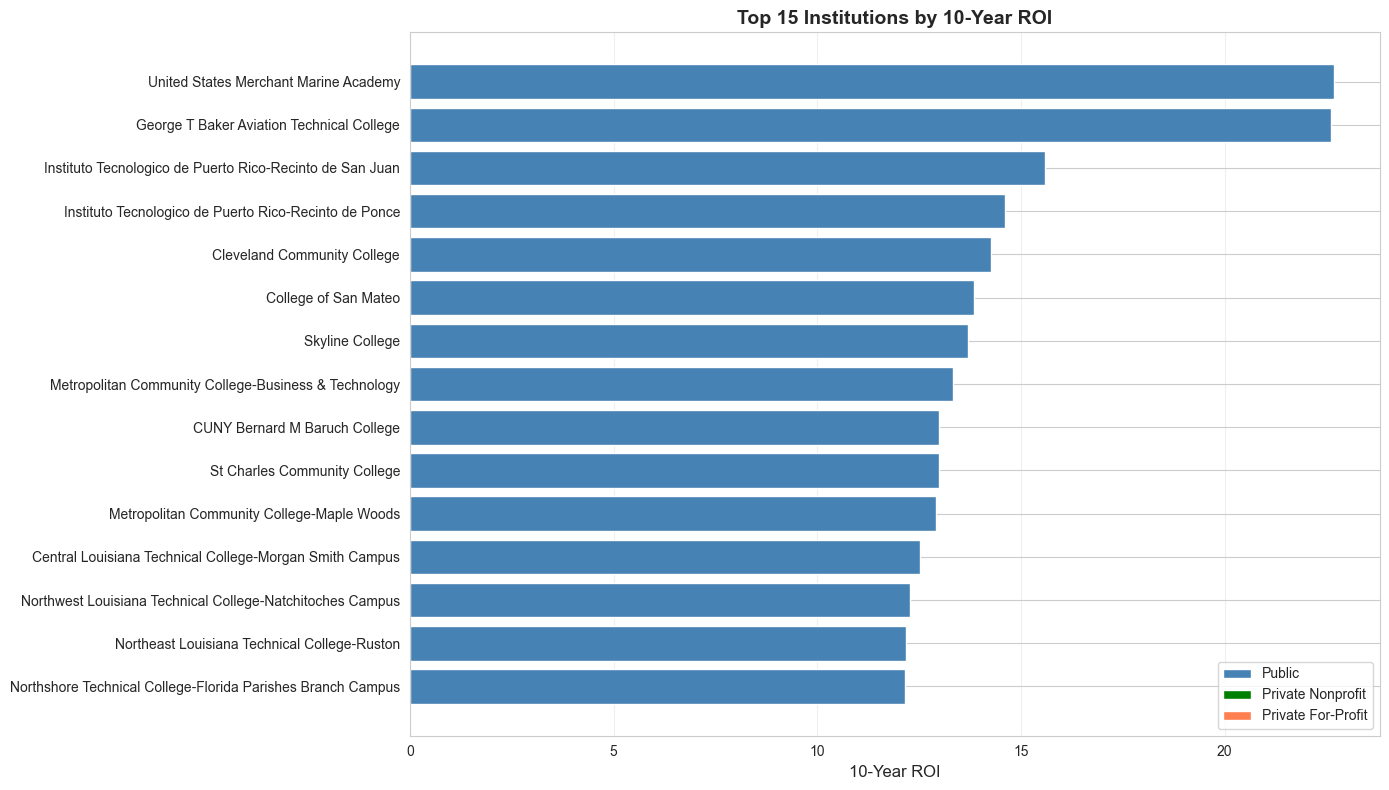


=== Top 20 Institutions by Median Earnings (Most Recent Year) ===
                                                 INSTNM STABBR       CONTROL_TYPE  MD_EARN_WNE_P10  ROI_10YR  GRAD_DEBT_MDN_SUPP
                  Massachusetts Institute of Technology     MA  Private Nonprofit         143372.0  3.899262             14768.0
                              Samuel Merritt University     CA  Private Nonprofit         143238.0       NaN             20825.0
                                    Harvey Mudd College     CA  Private Nonprofit         138687.0  3.359088             25000.0
University of Health Sciences and Pharmacy in St. Louis     MO  Private Nonprofit         137047.0  6.288959             17755.0
         Albany College of Pharmacy and Health Sciences     NY  Private Nonprofit         131426.0  5.528733             25500.0
                 Franklin W Olin College of Engineering     MA  Private Nonprofit         129455.0  3.356642             19500.0
                     Californi

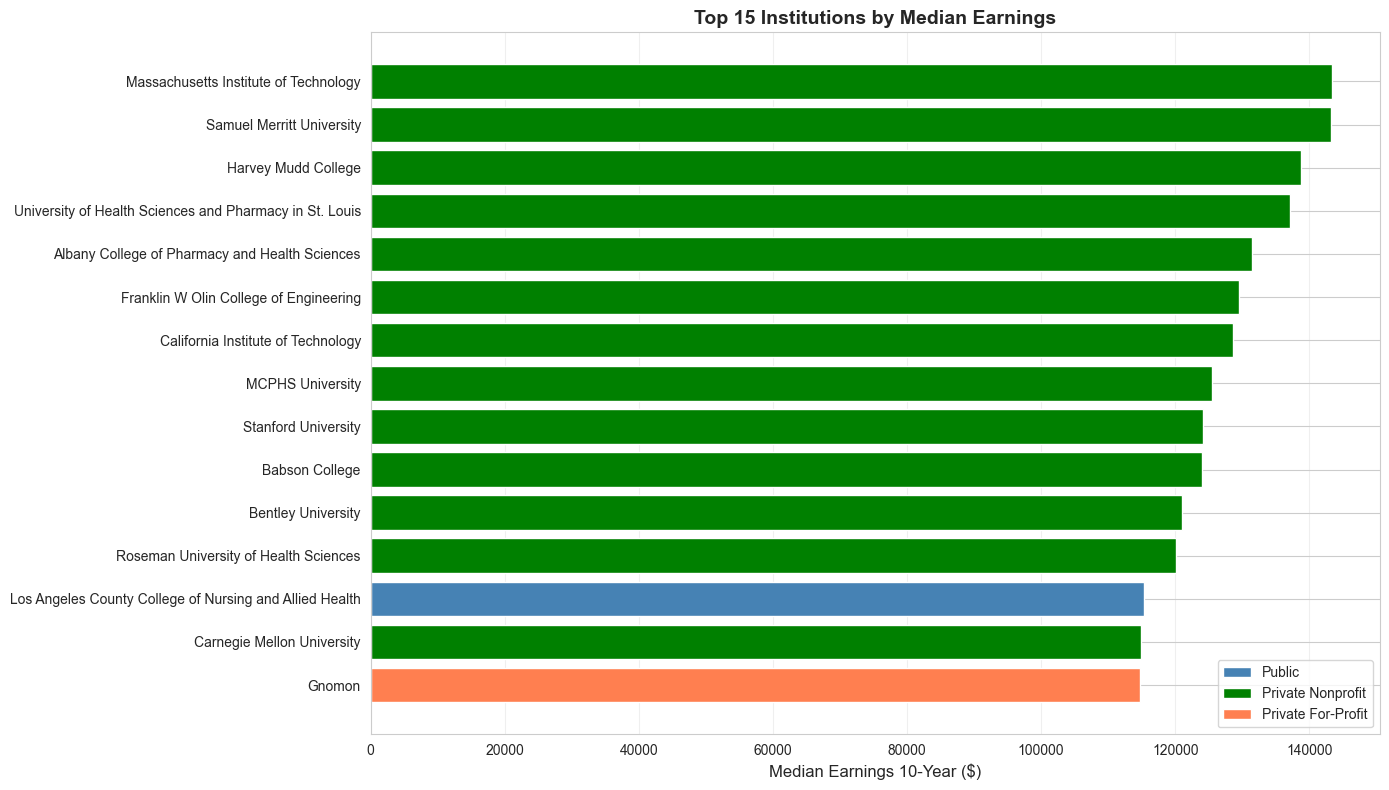

In [44]:
# Identify top performing institutions
# We'll look at the most recent year for each institution
df_recent = df_viz.sort_values('YEAR_INT').groupby('UNITID').last().reset_index()

# Top institutions by ROI
print("=== Top 20 Institutions by ROI (Most Recent Year) ===")
top_roi_schools = df_recent.nlargest(20, 'ROI_10YR')[['INSTNM', 'STABBR', 'CONTROL_TYPE', 'ROI_10YR',
                                                         'MD_EARN_WNE_P10', 'COSTT4_A', 'GRAD_DEBT_MDN_SUPP']]
print(top_roi_schools.to_string(index=False))

# Visualize top 15 by ROI
plt.figure(figsize=(14, 8))
top_15_roi = df_recent.nlargest(15, 'ROI_10YR')
colors = ['steelblue' if ct == 'Public' else 'green' if ct == 'Private Nonprofit' else 'coral'
          for ct in top_15_roi['CONTROL_TYPE']]
plt.barh(range(len(top_15_roi)), top_15_roi['ROI_10YR'], color=colors)
plt.yticks(range(len(top_15_roi)), top_15_roi['INSTNM'], fontsize=10)
plt.xlabel('10-Year ROI', fontsize=12)
plt.title('Top 15 Institutions by 10-Year ROI', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Public'),
                   Patch(facecolor='green', label='Private Nonprofit'),
                   Patch(facecolor='coral', label='Private For-Profit')]
plt.legend(handles=legend_elements, loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Top institutions by Earnings
print("\n=== Top 20 Institutions by Median Earnings (Most Recent Year) ===")
top_earn_schools = df_recent.nlargest(20, 'MD_EARN_WNE_P10')[['INSTNM', 'STABBR', 'CONTROL_TYPE',
                                                                 'MD_EARN_WNE_P10', 'ROI_10YR', 'GRAD_DEBT_MDN_SUPP']]
print(top_earn_schools.to_string(index=False))

# Visualize top 15 by Earnings
plt.figure(figsize=(14, 8))
top_15_earn = df_recent.nlargest(15, 'MD_EARN_WNE_P10')
colors = ['steelblue' if ct == 'Public' else 'green' if ct == 'Private Nonprofit' else 'coral'
          for ct in top_15_earn['CONTROL_TYPE']]
plt.barh(range(len(top_15_earn)), top_15_earn['MD_EARN_WNE_P10'], color=colors)
plt.yticks(range(len(top_15_earn)), top_15_earn['INSTNM'], fontsize=10)
plt.xlabel('Median Earnings 10-Year ($)', fontsize=12)
plt.title('Top 15 Institutions by Median Earnings', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.legend(handles=legend_elements, loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Institution Size and Selectivity Analysis

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2764724145.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_size, x='SIZE_CATEGORY', y='ROI_10YR', order=size_order,
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2764724145.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sel, x='SELECTIVITY', y='MD_EARN_WNE_P10', order=selectivity_order,
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/2764724145.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_comp_size, x

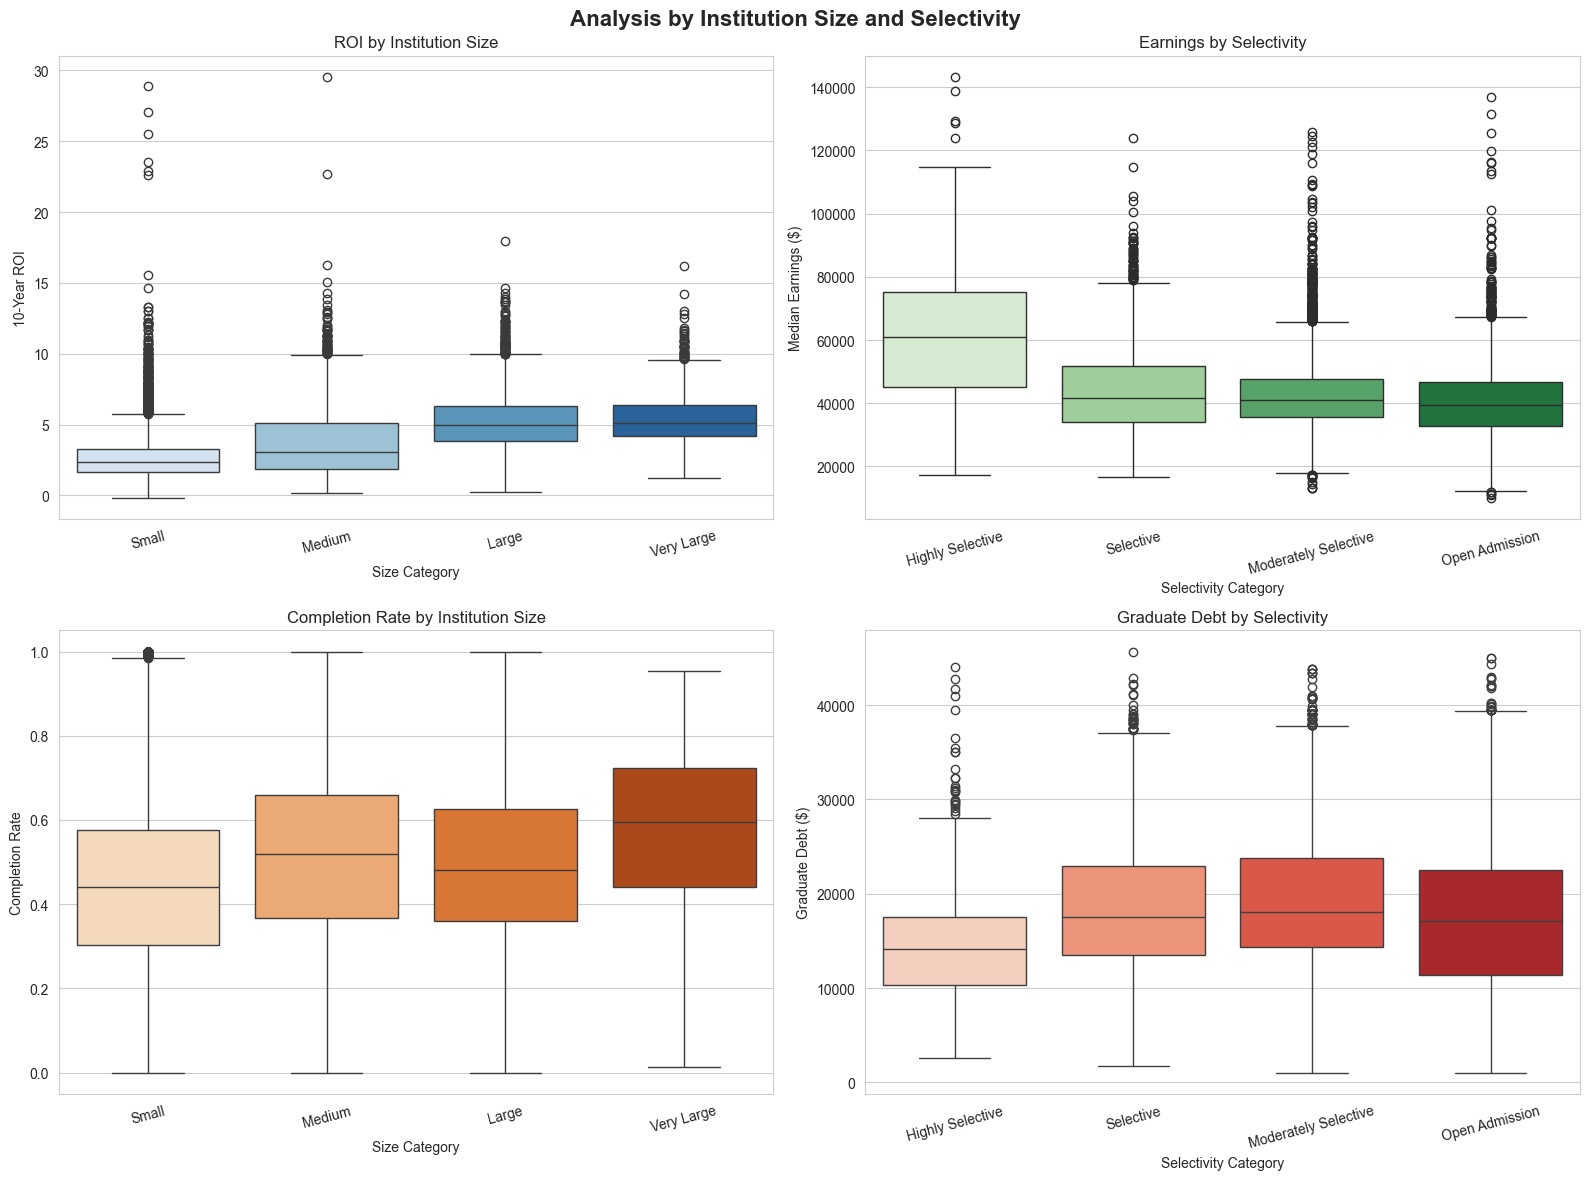


=== ROI by Size Category ===
                count      mean       50%
SIZE_CATEGORY                            
Large          3783.0  5.139407  4.973964
Medium         8950.0  3.619768  3.041769
Small          7491.0  2.745939  2.331135
Very Large     1429.0  5.397059  5.099266

=== Earnings by Selectivity ===
                       count          mean      50%
SELECTIVITY                                        
Highly Selective       452.0  60595.480088  60850.0
Moderately Selective  5980.0  42653.754013  41137.0
Open Admission        5565.0  40270.769272  39400.0
Selective             2300.0  43837.183478  41700.0


In [45]:
# Analysis by institution size and selectivity
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analysis by Institution Size and Selectivity', fontsize=16, fontweight='bold')

# 1. ROI by Size Category
df_size = df_viz[df_viz['SIZE_CATEGORY'].notna() & df_viz['ROI_10YR'].notna()]
size_order = ['Small', 'Medium', 'Large', 'Very Large']
sns.boxplot(data=df_size, x='SIZE_CATEGORY', y='ROI_10YR', order=size_order,
            ax=axes[0,0], palette='Blues')
axes[0,0].set_title('ROI by Institution Size')
axes[0,0].set_xlabel('Size Category')
axes[0,0].set_ylabel('10-Year ROI')
axes[0,0].tick_params(axis='x', rotation=15)

# 2. Earnings by Selectivity
df_sel = df_viz[df_viz['SELECTIVITY'].notna() & df_viz['MD_EARN_WNE_P10'].notna()]
selectivity_order = ['Highly Selective', 'Selective', 'Moderately Selective', 'Open Admission']
sns.boxplot(data=df_sel, x='SELECTIVITY', y='MD_EARN_WNE_P10', order=selectivity_order,
            ax=axes[0,1], palette='Greens')
axes[0,1].set_title('Earnings by Selectivity')
axes[0,1].set_xlabel('Selectivity Category')
axes[0,1].set_ylabel('Median Earnings ($)')
axes[0,1].tick_params(axis='x', rotation=15)

# 3. Completion Rate by Size
df_comp_size = df_viz[df_viz['SIZE_CATEGORY'].notna() & df_viz['C150_4'].notna()]
sns.boxplot(data=df_comp_size, x='SIZE_CATEGORY', y='C150_4', order=size_order,
            ax=axes[1,0], palette='Oranges')
axes[1,0].set_title('Completion Rate by Institution Size')
axes[1,0].set_xlabel('Size Category')
axes[1,0].set_ylabel('Completion Rate')
axes[1,0].tick_params(axis='x', rotation=15)

# 4. Debt by Selectivity
df_debt_sel = df_viz[df_viz['SELECTIVITY'].notna() & df_viz['GRAD_DEBT_MDN_SUPP'].notna()]
sns.boxplot(data=df_debt_sel, x='SELECTIVITY', y='GRAD_DEBT_MDN_SUPP', order=selectivity_order,
            ax=axes[1,1], palette='Reds')
axes[1,1].set_title('Graduate Debt by Selectivity')
axes[1,1].set_xlabel('Selectivity Category')
axes[1,1].set_ylabel('Graduate Debt ($)')
axes[1,1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== ROI by Size Category ===")
print(df_size.groupby('SIZE_CATEGORY')['ROI_10YR'].describe()[['count', 'mean', '50%']])

print("\n=== Earnings by Selectivity ===")
print(df_sel.groupby('SELECTIVITY')['MD_EARN_WNE_P10'].describe()[['count', 'mean', '50%']])

## 4. Summary Dashboard

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3626009428.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


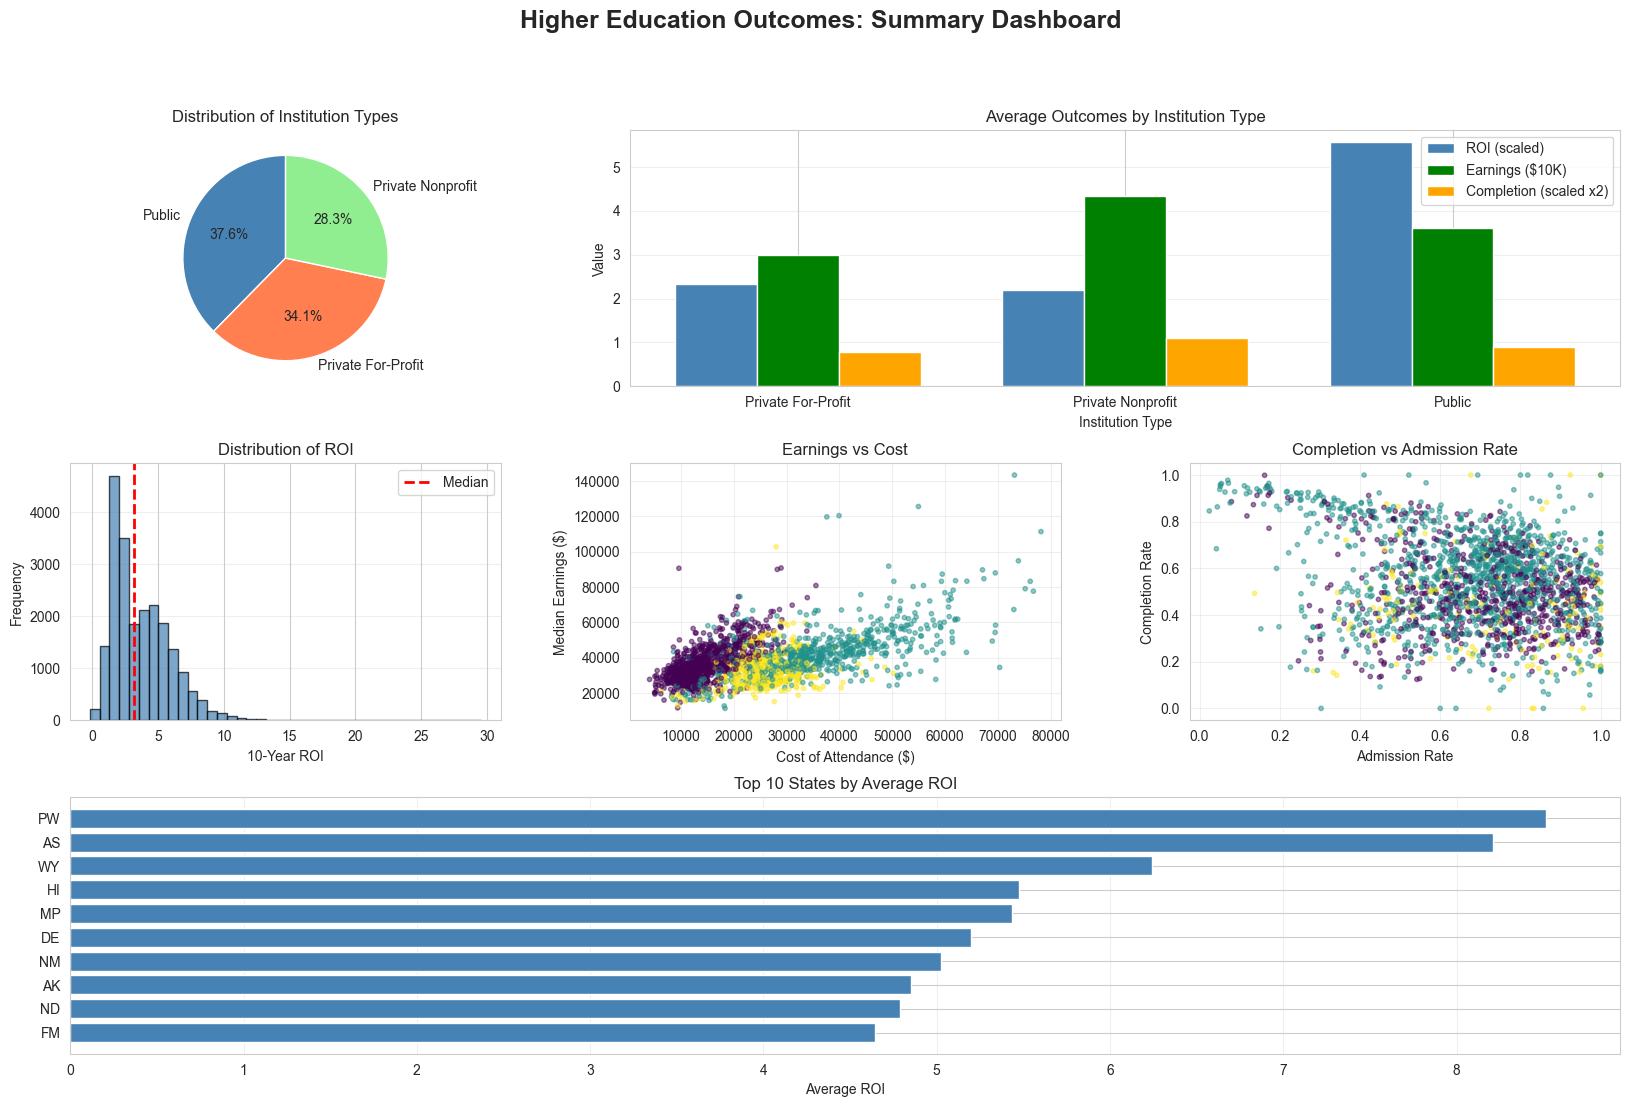

In [46]:
# Create a comprehensive summary dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Higher Education Outcomes: Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Institution Type Distribution (Pie Chart)
ax1 = fig.add_subplot(gs[0, 0])
control_counts = df_viz['CONTROL_TYPE'].value_counts()
colors_pie = ['steelblue', 'coral', 'lightgreen']
ax1.pie(control_counts, labels=control_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors_pie)
ax1.set_title('Distribution of Institution Types')

# 2. Average Metrics by Type (Bar Chart)
ax2 = fig.add_subplot(gs[0, 1:])
metrics_by_type = df_viz.groupby('CONTROL_TYPE').agg({
    'ROI_10YR': 'mean',
    'MD_EARN_WNE_P10': 'mean',
    'C150_4': 'mean'
}).reset_index()

x = np.arange(len(metrics_by_type))
width = 0.25
ax2.bar(x - width, metrics_by_type['ROI_10YR'], width, label='ROI (scaled)', color='steelblue')
ax2.bar(x, metrics_by_type['MD_EARN_WNE_P10']/10000, width, label='Earnings ($10K)', color='green')
ax2.bar(x + width, metrics_by_type['C150_4']*2, width, label='Completion (scaled x2)', color='orange')
ax2.set_xlabel('Institution Type')
ax2.set_ylabel('Value')
ax2.set_title('Average Outcomes by Institution Type')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_by_type['CONTROL_TYPE'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. ROI Distribution (Histogram)
ax3 = fig.add_subplot(gs[1, 0])
df_viz['ROI_10YR'].dropna().hist(bins=40, ax=ax3, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(df_viz['ROI_10YR'].median(), color='red', linestyle='--', linewidth=2, label='Median')
ax3.set_xlabel('10-Year ROI')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of ROI')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Earnings vs Cost (Scatter)
ax4 = fig.add_subplot(gs[1, 1])
df_scatter = df_viz[df_viz['COSTT4_A'].notna() & df_viz['MD_EARN_WNE_P10'].notna()].sample(n=min(2000, len(df_viz)))
scatter = ax4.scatter(df_scatter['COSTT4_A'], df_scatter['MD_EARN_WNE_P10'],
                      c=df_scatter['CONTROL'], cmap='viridis', alpha=0.5, s=10)
ax4.set_xlabel('Cost of Attendance ($)')
ax4.set_ylabel('Median Earnings ($)')
ax4.set_title('Earnings vs Cost')
ax4.grid(True, alpha=0.3)

# 5. Completion Rate vs Admission Rate (Scatter)
ax5 = fig.add_subplot(gs[1, 2])
df_scatter2 = df_viz[df_viz['ADM_RATE'].notna() & df_viz['C150_4'].notna()].sample(n=min(2000, len(df_viz)))
scatter2 = ax5.scatter(df_scatter2['ADM_RATE'], df_scatter2['C150_4'],
                       c=df_scatter2['CONTROL'], cmap='viridis', alpha=0.5, s=10)
ax5.set_xlabel('Admission Rate')
ax5.set_ylabel('Completion Rate')
ax5.set_title('Completion vs Admission Rate')
ax5.grid(True, alpha=0.3)

# 6. Top 10 States by ROI (Bar Chart)
ax6 = fig.add_subplot(gs[2, :])
state_roi = df_viz.groupby('STABBR')['ROI_10YR'].mean().nlargest(10).sort_values()
ax6.barh(range(len(state_roi)), state_roi.values, color='steelblue')
ax6.set_yticks(range(len(state_roi)))
ax6.set_yticklabels(state_roi.index)
ax6.set_xlabel('Average ROI')
ax6.set_title('Top 10 States by Average ROI')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/1394578066.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_size_roi, x='SIZE_CATEGORY', y='ROI_10YR', ax=axes[0,0], palette='Set3')
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/1394578066.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sel_roi, x='SELECTIVITY', y='ROI_10YR', ax=axes[0,1], palette='Set2')
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/1394578066.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.viol

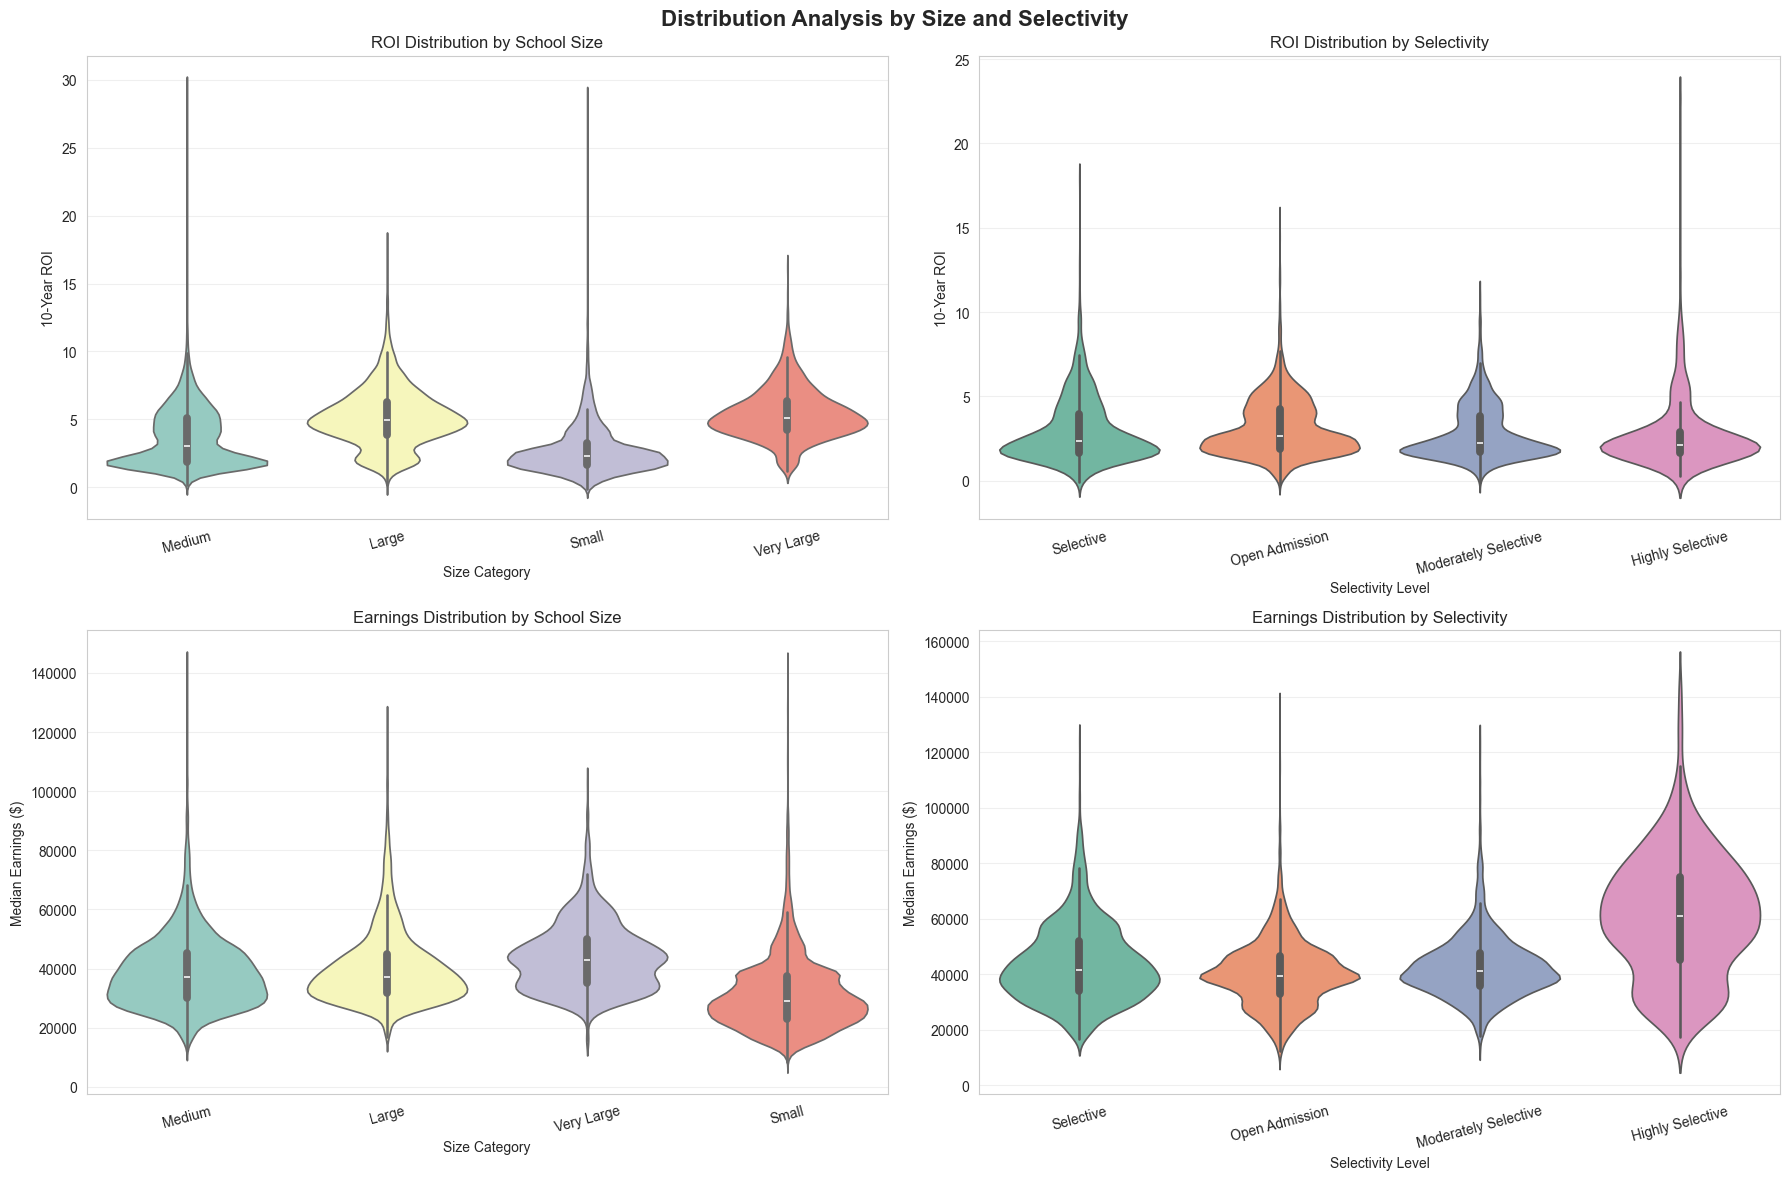


=== Average ROI by Size and Selectivity ===
SELECTIVITY    Highly Selective  Moderately Selective  Open Admission  \
SIZE_CATEGORY                                                           
Large                  2.803416              4.110942        4.450004   
Medium                 2.260404              2.408602        2.756634   
Small                  3.310404              2.335746        2.626457   
Very Large             3.484932              4.647408        4.723356   

SELECTIVITY    Selective  
SIZE_CATEGORY             
Large           4.011770  
Medium          2.427060  
Small           2.555082  
Very Large      5.081990  


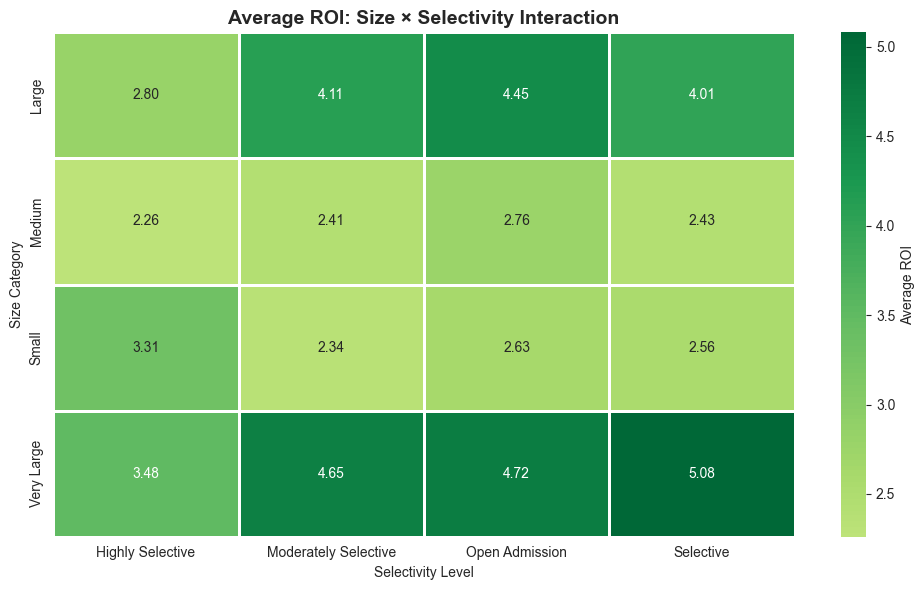


=== Key Insights ===
Highest ROI combination: 5.08
Location: ('Very Large', 'Selective')

Lowest ROI combination: 2.26
Location: ('Medium', 'Highly Selective')


In [47]:
# Violin plots by Size & Selectivity
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Distribution Analysis by Size and Selectivity', fontsize=16, fontweight='bold')

# 1. ROI by Size Category
df_size_roi = df_viz[df_viz['ROI_10YR'].notna() & df_viz['SIZE_CATEGORY'].notna()]
sns.violinplot(data=df_size_roi, x='SIZE_CATEGORY', y='ROI_10YR', ax=axes[0,0], palette='Set3')
axes[0,0].set_title('ROI Distribution by School Size')
axes[0,0].set_xlabel('Size Category')
axes[0,0].set_ylabel('10-Year ROI')
axes[0,0].tick_params(axis='x', rotation=15)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. ROI by Selectivity
df_sel_roi = df_viz[df_viz['ROI_10YR'].notna() & df_viz['SELECTIVITY'].notna()]
sns.violinplot(data=df_sel_roi, x='SELECTIVITY', y='ROI_10YR', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('ROI Distribution by Selectivity')
axes[0,1].set_xlabel('Selectivity Level')
axes[0,1].set_ylabel('10-Year ROI')
axes[0,1].tick_params(axis='x', rotation=15)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Earnings by Size Category
df_size_earn = df_viz[df_viz['MD_EARN_WNE_P10'].notna() & df_viz['SIZE_CATEGORY'].notna()]
sns.violinplot(data=df_size_earn, x='SIZE_CATEGORY', y='MD_EARN_WNE_P10', ax=axes[1,0], palette='Set3')
axes[1,0].set_title('Earnings Distribution by School Size')
axes[1,0].set_xlabel('Size Category')
axes[1,0].set_ylabel('Median Earnings ($)')
axes[1,0].tick_params(axis='x', rotation=15)
axes[1,0].grid(axis='y', alpha=0.3)

# 4. Earnings by Selectivity
df_sel_earn = df_viz[df_viz['MD_EARN_WNE_P10'].notna() & df_viz['SELECTIVITY'].notna()]
sns.violinplot(data=df_sel_earn, x='SELECTIVITY', y='MD_EARN_WNE_P10', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Earnings Distribution by Selectivity')
axes[1,1].set_xlabel('Selectivity Level')
axes[1,1].set_ylabel('Median Earnings ($)')
axes[1,1].tick_params(axis='x', rotation=15)
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cross-tabulation: Size × Selectivity → Average ROI
print("\n=== Average ROI by Size and Selectivity ===")
df_cross = df_viz[df_viz['ROI_10YR'].notna() &
                  df_viz['SIZE_CATEGORY'].notna() &
                  df_viz['SELECTIVITY'].notna()]
crosstab_roi = pd.crosstab(
    df_cross['SIZE_CATEGORY'],
    df_cross['SELECTIVITY'],
    values=df_cross['ROI_10YR'],
    aggfunc='mean'
)
print(crosstab_roi)

# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_roi, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
            linewidths=1, cbar_kws={"label": "Average ROI"})
plt.title('Average ROI: Size × Selectivity Interaction', fontsize=14, fontweight='bold')
plt.xlabel('Selectivity Level')
plt.ylabel('Size Category')
plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== Key Insights ===")
print(f"Highest ROI combination: {crosstab_roi.max().max():.2f}")
print(f"Location: {crosstab_roi.stack().idxmax()}")
print(f"\nLowest ROI combination: {crosstab_roi.min().min():.2f}")
print(f"Location: {crosstab_roi.stack().idxmin()}")

Checking available years with ROI data...

Most recent years with data:
YEAR
2009_10    3625
2011_12    3788
2012_13    3768
2013_14    3757
2014_15    3678
2020_21    3037
dtype: int64

Using year: 2020_21 (4453 records)

TOP 20 INSTITUTIONS BY ROI
                                                      INSTNM STABBR CONTROL_TYPE   ROI_10YR  MD_EARN_WNE_P10  TUITIONFEE_IN  GRAD_DEBT_MDN_SUPP  C150_4
1                      United States Merchant Marine Academy     NY       Public  22.682697          90610.0         1095.0              8833.0  0.8233
2   Instituto Tecnologico de Puerto Rico-Recinto de San Juan     PR       Public  15.590737          26293.0         3707.0                 NaN     NaN
3      Instituto Tecnologico de Puerto Rico-Recinto de Ponce     PR       Public  14.609713          26293.0         1130.0                 NaN     NaN
4                                Cleveland Community College     NC       Public  14.265467          33755.0         2602.0                 Na

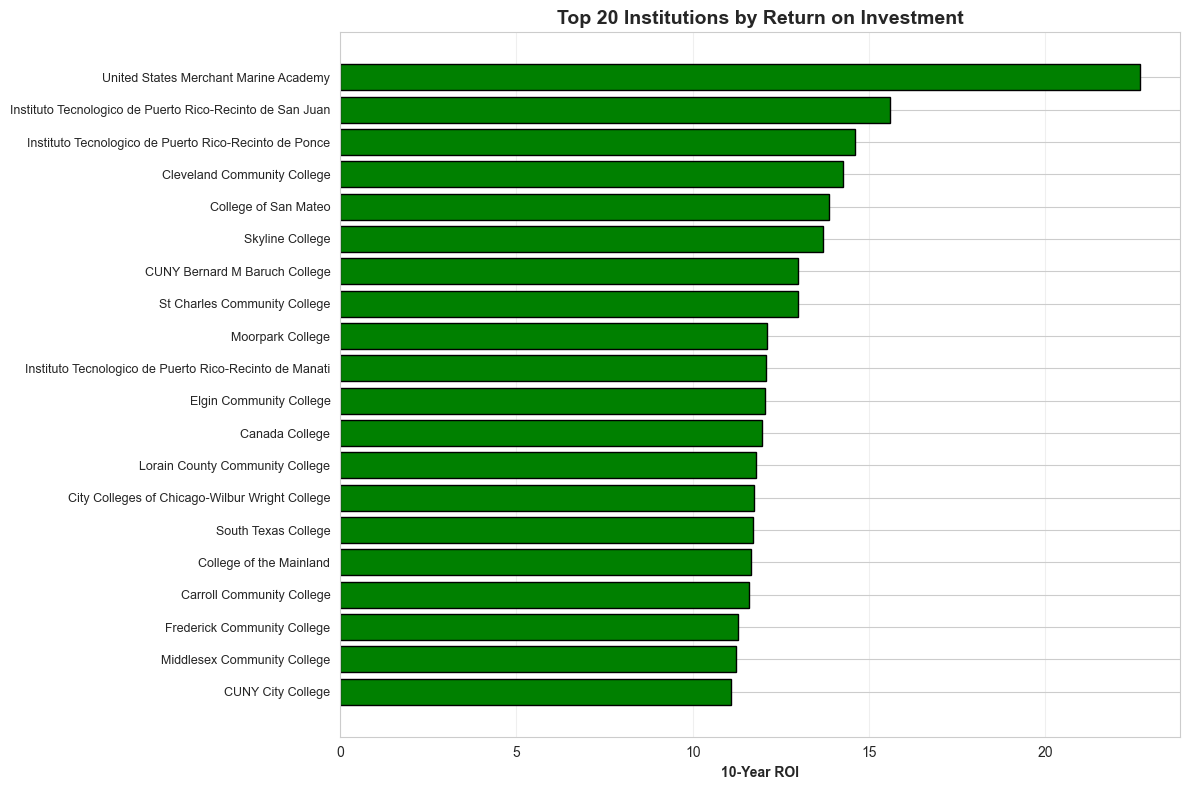


WORST 20 INSTITUTIONS BY DEBT-TO-EARNINGS RATIO
                                   INSTNM STABBR        CONTROL_TYPE  DEBT_TO_EARNINGS  GRAD_DEBT_MDN_SUPP  MD_EARN_WNE_P6  TUITIONFEE_IN  C150_4
1                       Martin University     IN   Private Nonprofit          1.644622             42002.0         25539.0        13200.0  0.1000
2                        Allen University     SC   Private Nonprofit          1.435389             34290.0         23889.0        13340.0  0.1905
3               Manhattan School of Music     NY   Private Nonprofit          1.434706             26994.0         18815.0        49270.0  0.7434
4   The New England Conservatory of Music     MA   Private Nonprofit          1.433882             27000.0         18830.0        52440.0  0.7067
5              Grambling State University     LA              Public          1.426394             36500.0         25589.0         7635.0  0.4211
6                 Universal Career School     FL  Private For-Profit       

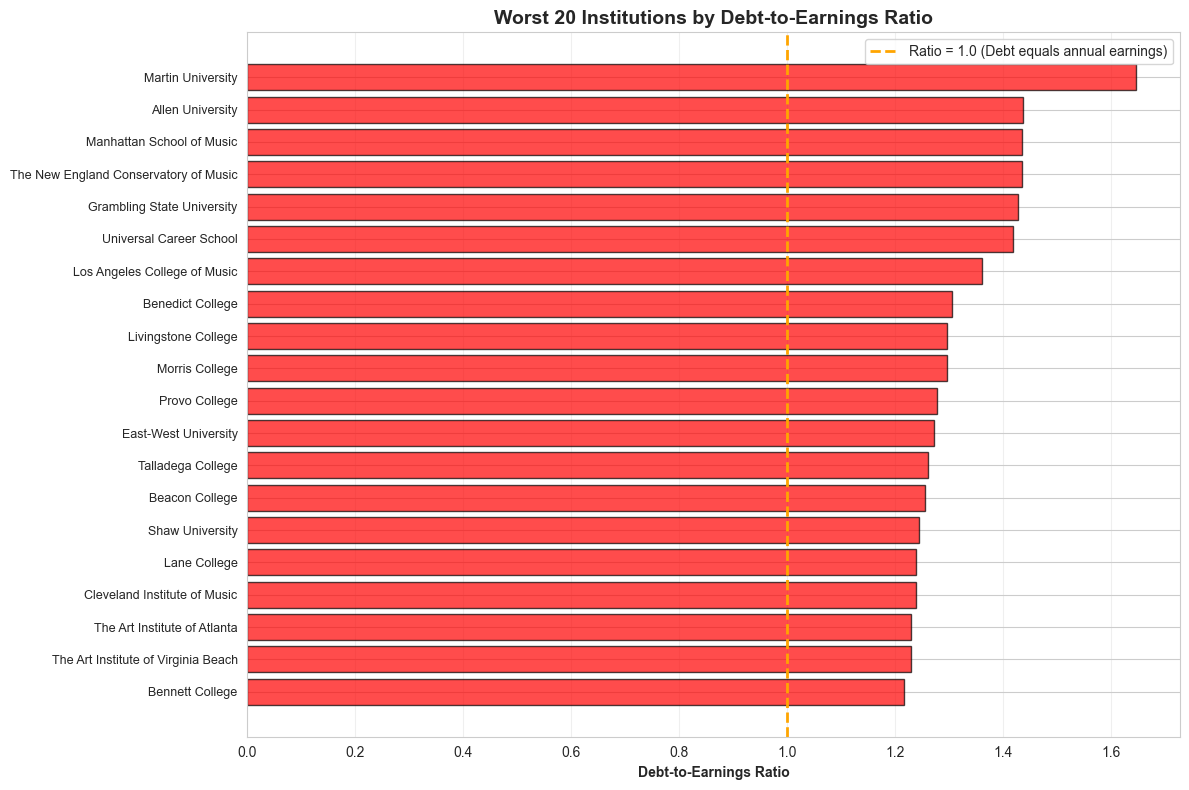


TOP 20 BEST VALUE SCHOOLS
Criteria: Completion Rate > 60%, Debt < $15k, ROI > 1.5
                                                                INSTNM STABBR       CONTROL_TYPE   ROI_10YR  C150_4  GRAD_DEBT_MDN_SUPP  MD_EARN_WNE_P10  TUITIONFEE_IN  VALUE_SCORE
1                                United States Merchant Marine Academy     NY             Public  22.682697  0.8233              8833.0          90610.0         1095.0     9.267071
2                                        CUNY Bernard M Baruch College     NY             Public  12.997163  0.7253             11512.0          75971.0         7462.0     5.347383
3                                             Brigham Young University     UT  Private Nonprofit   9.006073  0.7545             11069.0          75790.0         5970.0     3.762365
4                               University of Washington-Tacoma Campus     WA             Public   8.037779  0.6034             14615.0          78466.0        11889.0     3.308442
5           

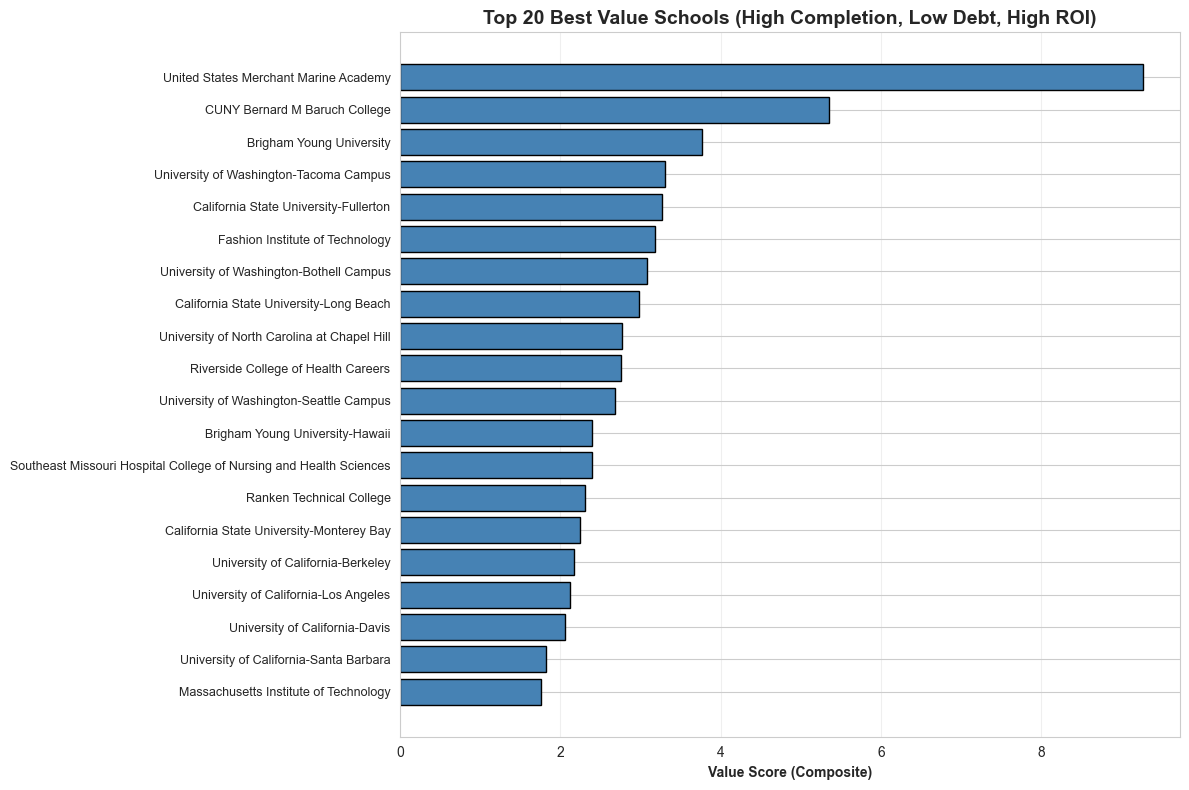


SUMMARY COMPARISON
              Category  Count   Avg ROI  Avg Earnings     Avg Debt  Avg Completion
            Top 20 ROI     20 13.046571      47026.75  9061.916667        0.521380
Worst 20 Debt/Earnings     20       NaN      23074.35 30501.000000        0.380553
            Best Value     20  7.303016      75417.85 12925.450000        0.797035

Institution Type Breakdown

Top ROI Schools:
CONTROL_TYPE
Public    20
Name: count, dtype: int64

Worst Debt/Earnings Schools:
CONTROL_TYPE
Private Nonprofit     14
Private For-Profit     5
Public                 1
Name: count, dtype: int64

Best Value Schools:
CONTROL_TYPE
Public               14
Private Nonprofit     6
Name: count, dtype: int64


In [48]:
# Analyze top and bottom performing institutions
# First, find the most recent year with sufficient data
print("Checking available years with ROI data...")
year_counts = df_viz[df_viz['ROI_10YR'].notna()].groupby('YEAR').size().sort_index()
print(f"\nMost recent years with data:")
print(year_counts.tail(10))

# Use the most recent year with substantial data (at least 100 records)
recent_years = year_counts[year_counts >= 100].tail(3)
if len(recent_years) > 0:
    most_recent_year = recent_years.index[-1]
    df_recent = df_viz[df_viz['YEAR'] == most_recent_year].copy()
    print(f"\nUsing year: {most_recent_year} ({len(df_recent)} records)")
else:
    # Fallback: use aggregated data across all years (average per institution)
    print("\nUsing aggregated data across all years (average per institution)")
    df_recent = df_viz.groupby('UNITID').agg({
        'INSTNM': 'first',
        'STABBR': 'first',
        'CONTROL_TYPE': 'first',
        'ROI_10YR': 'mean',
        'MD_EARN_WNE_P10': 'mean',
        'MD_EARN_WNE_P6': 'mean',
        'TUITIONFEE_IN': 'mean',
        'GRAD_DEBT_MDN_SUPP': 'mean',
        'C150_4': 'mean',
        'DEBT_TO_EARNINGS': 'mean'
    }).reset_index()

# ============================================================================
# 1. TOP 20 INSTITUTIONS BY ROI
# ============================================================================
print("\n" + "="*80)
print("TOP 20 INSTITUTIONS BY ROI")
print("="*80)

top_roi = df_recent[df_recent['ROI_10YR'].notna()].nlargest(20, 'ROI_10YR')[
    ['INSTNM', 'STABBR', 'CONTROL_TYPE', 'ROI_10YR', 'MD_EARN_WNE_P10',
     'TUITIONFEE_IN', 'GRAD_DEBT_MDN_SUPP', 'C150_4']
].copy()

if len(top_roi) == 0:
    print("No data available for ROI analysis")
else:
    top_roi.reset_index(drop=True, inplace=True)
    top_roi.index = top_roi.index + 1
    print(top_roi.to_string())

    # Visualize Top 20 ROI
    n_schools = len(top_roi)
    plt.figure(figsize=(12, max(8, n_schools * 0.4)))
    plt.barh(range(n_schools), top_roi['ROI_10YR'].values[::-1], color='green', edgecolor='black')
    plt.yticks(range(n_schools), top_roi['INSTNM'].values[::-1], fontsize=9)
    plt.xlabel('10-Year ROI', fontweight='bold')
    plt.title(f'Top {n_schools} Institutions by Return on Investment',
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 2. WORST 20 BY DEBT-TO-EARNINGS RATIO
# ============================================================================
print("\n" + "="*80)
print("WORST 20 INSTITUTIONS BY DEBT-TO-EARNINGS RATIO")
print("="*80)

worst_debt_ratio = df_recent[df_recent['DEBT_TO_EARNINGS'].notna()].nlargest(20, 'DEBT_TO_EARNINGS')[
    ['INSTNM', 'STABBR', 'CONTROL_TYPE', 'DEBT_TO_EARNINGS', 'GRAD_DEBT_MDN_SUPP',
     'MD_EARN_WNE_P6', 'TUITIONFEE_IN', 'C150_4']
].copy()

if len(worst_debt_ratio) == 0:
    print("No data available for Debt-to-Earnings analysis")
else:
    worst_debt_ratio.reset_index(drop=True, inplace=True)
    worst_debt_ratio.index = worst_debt_ratio.index + 1
    print(worst_debt_ratio.to_string())

    # Visualize Worst 20 Debt-to-Earnings
    n_schools = len(worst_debt_ratio)
    plt.figure(figsize=(12, max(8, n_schools * 0.4)))
    plt.barh(range(n_schools), worst_debt_ratio['DEBT_TO_EARNINGS'].values[::-1],
             color='red', edgecolor='black', alpha=0.7)
    plt.yticks(range(n_schools), worst_debt_ratio['INSTNM'].values[::-1], fontsize=9)
    plt.xlabel('Debt-to-Earnings Ratio', fontweight='bold')
    plt.title(f'Worst {n_schools} Institutions by Debt-to-Earnings Ratio',
              fontsize=14, fontweight='bold')
    plt.axvline(x=1.0, color='orange', linestyle='--', linewidth=2,
                label='Ratio = 1.0 (Debt equals annual earnings)')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 3. BEST VALUE SCHOOLS (High Completion + Low Debt + High ROI)
# ============================================================================
print("\n" + "="*80)
print("TOP 20 BEST VALUE SCHOOLS")
print("Criteria: Completion Rate > 60%, Debt < $15k, ROI > 1.5")
print("="*80)

# Filter for "best value" criteria
df_value = df_recent[
    (df_recent['C150_4'] > 0.60) &
    (df_recent['GRAD_DEBT_MDN_SUPP'] < 15000) &
    (df_recent['ROI_10YR'] > 1.5)
].copy()

if len(df_value) == 0:
    print("No schools meet all criteria. Relaxing constraints...")
    # Try relaxed criteria
    df_value = df_recent[
        (df_recent['C150_4'] > 0.50) &
        (df_recent['GRAD_DEBT_MDN_SUPP'] < 20000) &
        (df_recent['ROI_10YR'] > 1.0)
    ].copy()
    print(f"Relaxed criteria: Completion > 50%, Debt < $20k, ROI > 1.0")
    print(f"Found {len(df_value)} schools")

if len(df_value) > 0:
    # Create a composite "value score" (weighted combination)
    # Higher completion, lower debt, higher ROI = better
    df_value['VALUE_SCORE'] = (
        df_value['ROI_10YR'] * 0.4 +
        df_value['C150_4'] * 0.3 -
        (df_value['GRAD_DEBT_MDN_SUPP'] / 50000) * 0.3  # Normalize debt
    )

    best_value = df_value.nlargest(min(20, len(df_value)), 'VALUE_SCORE')[
        ['INSTNM', 'STABBR', 'CONTROL_TYPE', 'ROI_10YR', 'C150_4',
         'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10', 'TUITIONFEE_IN', 'VALUE_SCORE']
    ].copy()
    best_value.reset_index(drop=True, inplace=True)
    best_value.index = best_value.index + 1
    print(best_value.to_string())

    # Visualize Best Value Schools
    n_schools = len(best_value)
    plt.figure(figsize=(12, max(8, n_schools * 0.4)))
    plt.barh(range(n_schools), best_value['VALUE_SCORE'].values[::-1],
             color='steelblue', edgecolor='black')
    plt.yticks(range(n_schools), best_value['INSTNM'].values[::-1], fontsize=9)
    plt.xlabel('Value Score (Composite)', fontweight='bold')
    plt.title(f'Top {n_schools} Best Value Schools (High Completion, Low Debt, High ROI)',
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No schools found meeting the criteria")
    best_value = pd.DataFrame()

# ============================================================================
# 4. SUMMARY STATISTICS
# ============================================================================
if len(top_roi) > 0 or len(worst_debt_ratio) > 0 or len(best_value) > 0:
    print("\n" + "="*80)
    print("SUMMARY COMPARISON")
    print("="*80)

    summary_data = {
        'Category': [],
        'Count': [],
        'Avg ROI': [],
        'Avg Earnings': [],
        'Avg Debt': [],
        'Avg Completion': []
    }

    if len(top_roi) > 0:
        summary_data['Category'].append('Top 20 ROI')
        summary_data['Count'].append(len(top_roi))
        summary_data['Avg ROI'].append(top_roi['ROI_10YR'].mean())
        summary_data['Avg Earnings'].append(top_roi['MD_EARN_WNE_P10'].mean())
        summary_data['Avg Debt'].append(top_roi['GRAD_DEBT_MDN_SUPP'].mean())
        summary_data['Avg Completion'].append(top_roi['C150_4'].mean())

    if len(worst_debt_ratio) > 0:
        summary_data['Category'].append('Worst 20 Debt/Earnings')
        summary_data['Count'].append(len(worst_debt_ratio))
        summary_data['Avg ROI'].append(np.nan)  # Not applicable
        summary_data['Avg Earnings'].append(worst_debt_ratio['MD_EARN_WNE_P6'].mean() if 'MD_EARN_WNE_P6' in worst_debt_ratio.columns else np.nan)
        summary_data['Avg Debt'].append(worst_debt_ratio['GRAD_DEBT_MDN_SUPP'].mean())
        summary_data['Avg Completion'].append(worst_debt_ratio['C150_4'].mean())

    if len(best_value) > 0:
        summary_data['Category'].append('Best Value')
        summary_data['Count'].append(len(best_value))
        summary_data['Avg ROI'].append(best_value['ROI_10YR'].mean())
        summary_data['Avg Earnings'].append(best_value['MD_EARN_WNE_P10'].mean())
        summary_data['Avg Debt'].append(best_value['GRAD_DEBT_MDN_SUPP'].mean())
        summary_data['Avg Completion'].append(best_value['C150_4'].mean())

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    print("\n" + "="*80)
    print("Institution Type Breakdown")
    print("="*80)

    if len(top_roi) > 0:
        print("\nTop ROI Schools:")
        print(top_roi['CONTROL_TYPE'].value_counts())

    if len(worst_debt_ratio) > 0:
        print("\nWorst Debt/Earnings Schools:")
        print(worst_debt_ratio['CONTROL_TYPE'].value_counts())

    if len(best_value) > 0:
        print("\nBest Value Schools:")
        print(best_value['CONTROL_TYPE'].value_counts())

### 3.5 Net Price and Cost Analysis by Institution Type

NET PRICE / COST ANALYSIS

NOTE: Net price by income quintile data had >50% missing values and was
excluded during cleaning. This analysis uses Tuition and Cost of Attendance
as proxies to examine affordability across institution types.


/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3780607147.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tuition, x='CONTROL_TYPE', y='TUITIONFEE_IN',
/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3780607147.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_cost, x='CONTROL_TYPE', y='COSTT4_A',


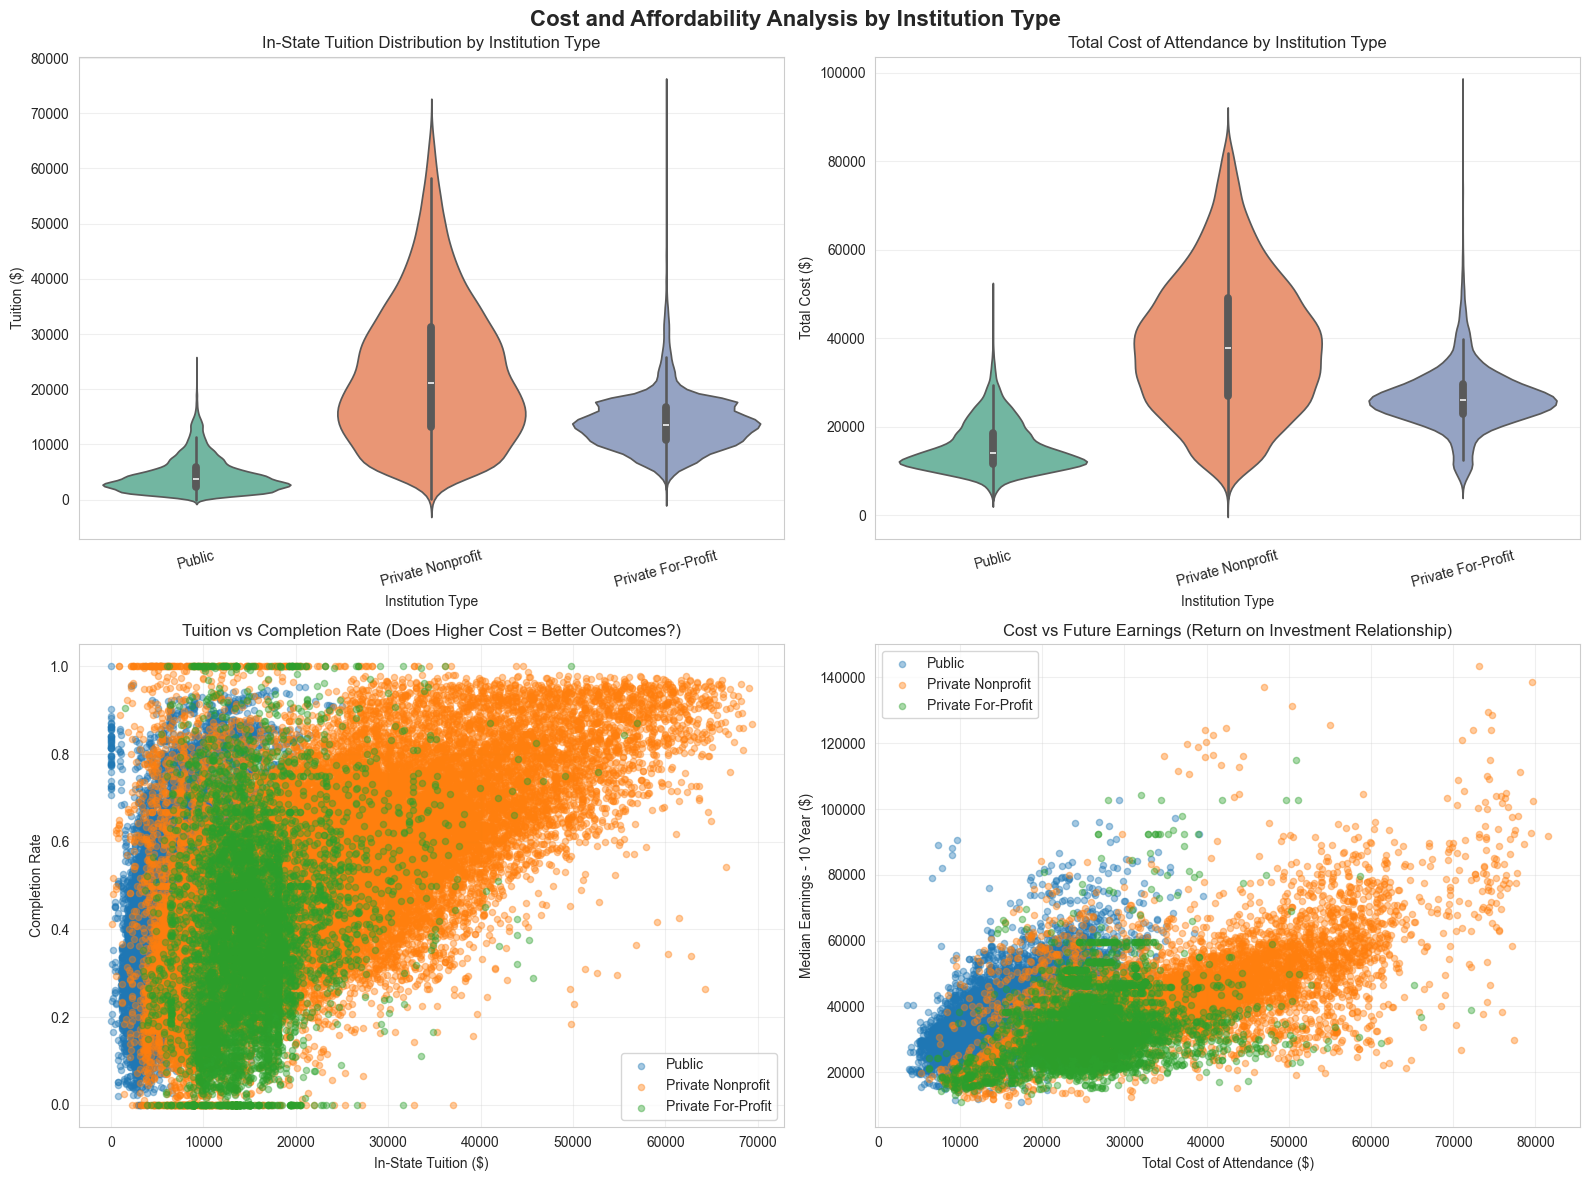


COST SUMMARY BY INSTITUTION TYPE

In-State Tuition:
                            mean   median  count
CONTROL_TYPE                                    
Private For-Profit  14105.101399  13600.0  16154
Private Nonprofit   23179.542223  21120.0  29652
Public               4526.222936   3676.0  37809

Total Cost of Attendance:
                            mean   median  count
CONTROL_TYPE                                    
Private For-Profit  26424.335649  25959.0   9790
Private Nonprofit   38673.197799  37738.0  18903
Public              15406.783766  13980.5  24048

AFFORDABILITY VS OUTCOMES ANALYSIS

Average Outcomes by Cost Quartile:
                    C150_4  MD_EARN_WNE_P10  GRAD_DEBT_MDN_SUPP  ROI_10YR
COST_QUARTILE                                                            
Low Cost (Q1)     0.349615     30682.972691         7888.195035  6.052559
Medium-Low (Q2)   0.422696     37048.516499        14414.315731  4.894408
Medium-High (Q3)  0.449581     36698.962314        18462.13245

/var/folders/my/8vyrs5l553lfj60cp39wqcbr0000gn/T/ipykernel_48334/3780607147.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_by_cost = df_afford.groupby('COST_QUARTILE').agg({


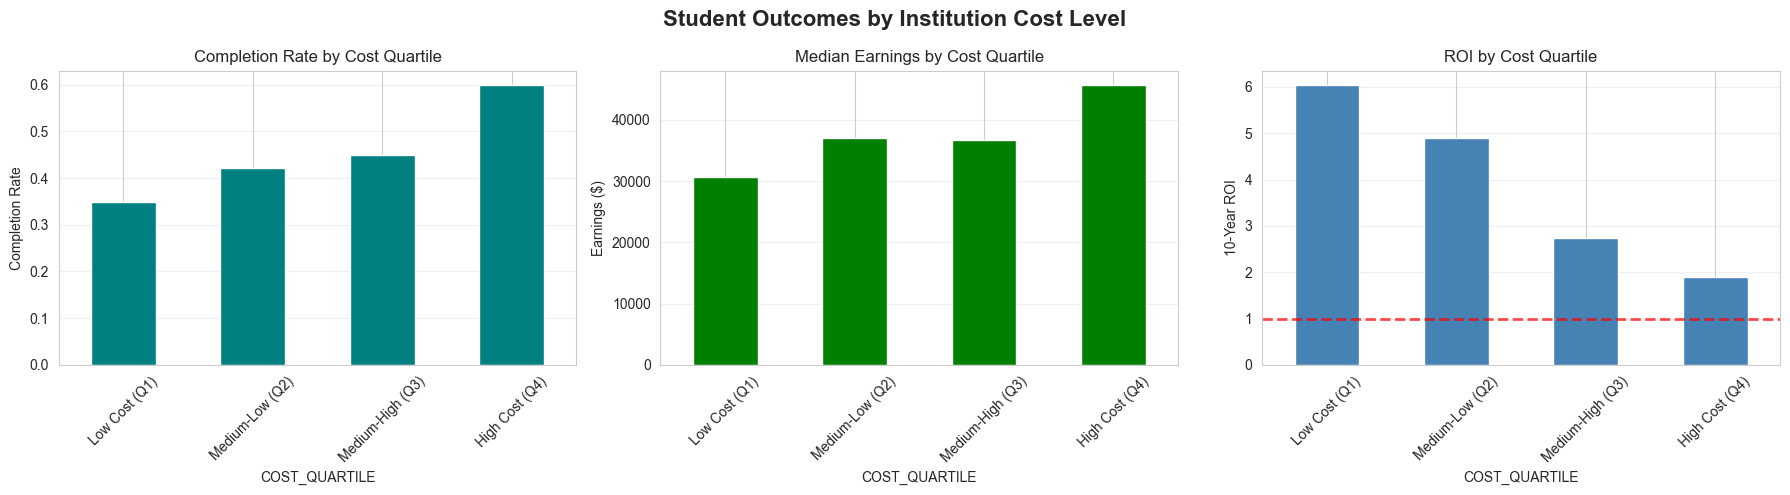


KEY FINDINGS

Correlation Analysis:
  Tuition vs Completion Rate: 0.518
  Cost vs Future Earnings: 0.556
  Tuition vs ROI: -0.657

Affordability Insights:
  Low-cost schools (Q1) average ROI: 6.05
  High-cost schools (Q4) average ROI: 1.90
  → Lower-cost institutions provide BETTER ROI on average!

DATA LIMITATION NOTE:
The original College Scorecard dataset includes 'Net Price by Income Quintile'
(NPT41-NPT45), which would allow analysis of affordability for students from
different economic backgrounds. However, this data had >50% missing values
in our dataset and was excluded during preprocessing.

Future work could:
  - Use more recent data with better net price coverage
  - Analyze net price trends for subset of institutions with complete data
  - Incorporate Pell Grant percentages as proxy for low-income accessibility


In [49]:
# Net Price by Income Quintile Analysis
# NOTE: Original NET_PRICE_Q1-Q5 columns were dropped due to >50% missing data
# Using TUITIONFEE_IN and COSTT4_A as proxies for cost analysis

print("="*80)
print("NET PRICE / COST ANALYSIS")
print("="*80)
print("\nNOTE: Net price by income quintile data had >50% missing values and was")
print("excluded during cleaning. This analysis uses Tuition and Cost of Attendance")
print("as proxies to examine affordability across institution types.")
print("="*80)

# Filter data with cost information
df_cost_analysis = df_viz[
    (df_viz['TUITIONFEE_IN'].notna()) | (df_viz['COSTT4_A'].notna())
].copy()

# ============================================================================
# 1. Cost Distribution by Institution Type
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cost and Affordability Analysis by Institution Type',
             fontsize=16, fontweight='bold')

# 1.1 Tuition by Institution Type
df_tuition = df_cost_analysis[df_cost_analysis['TUITIONFEE_IN'].notna()]
sns.violinplot(data=df_tuition, x='CONTROL_TYPE', y='TUITIONFEE_IN',
               ax=axes[0,0], palette='Set2')
axes[0,0].set_title('In-State Tuition Distribution by Institution Type')
axes[0,0].set_xlabel('Institution Type')
axes[0,0].set_ylabel('Tuition ($)')
axes[0,0].tick_params(axis='x', rotation=15)
axes[0,0].grid(axis='y', alpha=0.3)

# 1.2 Total Cost of Attendance by Institution Type
df_cost = df_cost_analysis[df_cost_analysis['COSTT4_A'].notna()]
sns.violinplot(data=df_cost, x='CONTROL_TYPE', y='COSTT4_A',
               ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Total Cost of Attendance by Institution Type')
axes[0,1].set_xlabel('Institution Type')
axes[0,1].set_ylabel('Total Cost ($)')
axes[0,1].tick_params(axis='x', rotation=15)
axes[0,1].grid(axis='y', alpha=0.3)

# 1.3 Tuition vs Completion Rate
df_complete = df_cost_analysis[
    df_cost_analysis['TUITIONFEE_IN'].notna() &
    df_cost_analysis['C150_4'].notna()
]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_complete[df_complete['CONTROL_TYPE'] == control_type]
    axes[1,0].scatter(df_type['TUITIONFEE_IN'], df_type['C150_4'],
                      alpha=0.4, s=20, label=control_type)
axes[1,0].set_xlabel('In-State Tuition ($)')
axes[1,0].set_ylabel('Completion Rate')
axes[1,0].set_title('Tuition vs Completion Rate (Does Higher Cost = Better Outcomes?)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 1.4 Cost vs Median Earnings
df_earnings = df_cost_analysis[
    df_cost_analysis['COSTT4_A'].notna() &
    df_cost_analysis['MD_EARN_WNE_P10'].notna()
]
for control_type in ['Public', 'Private Nonprofit', 'Private For-Profit']:
    df_type = df_earnings[df_earnings['CONTROL_TYPE'] == control_type]
    axes[1,1].scatter(df_type['COSTT4_A'], df_type['MD_EARN_WNE_P10'],
                      alpha=0.4, s=20, label=control_type)
axes[1,1].set_xlabel('Total Cost of Attendance ($)')
axes[1,1].set_ylabel('Median Earnings - 10 Year ($)')
axes[1,1].set_title('Cost vs Future Earnings (Return on Investment Relationship)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 2. Summary Statistics by Institution Type
# ============================================================================
print("\n" + "="*80)
print("COST SUMMARY BY INSTITUTION TYPE")
print("="*80)

cost_summary = df_cost_analysis.groupby('CONTROL_TYPE').agg({
    'TUITIONFEE_IN': ['mean', 'median', 'count'],
    'COSTT4_A': ['mean', 'median', 'count']
})

print("\nIn-State Tuition:")
print(cost_summary['TUITIONFEE_IN'])
print("\nTotal Cost of Attendance:")
print(cost_summary['COSTT4_A'])

# ============================================================================
# 3. Affordability Analysis - Cost vs Outcomes
# ============================================================================
print("\n" + "="*80)
print("AFFORDABILITY VS OUTCOMES ANALYSIS")
print("="*80)

# Create cost quartiles
df_afford = df_cost_analysis[df_cost_analysis['TUITIONFEE_IN'].notna()].copy()
df_afford['COST_QUARTILE'] = pd.qcut(df_afford['TUITIONFEE_IN'],
                                      q=4,
                                      labels=['Low Cost (Q1)', 'Medium-Low (Q2)',
                                             'Medium-High (Q3)', 'High Cost (Q4)'])

# Compare outcomes by cost quartile
outcome_by_cost = df_afford.groupby('COST_QUARTILE').agg({
    'C150_4': 'mean',
    'MD_EARN_WNE_P10': 'mean',
    'GRAD_DEBT_MDN_SUPP': 'mean',
    'ROI_10YR': 'mean'
})

print("\nAverage Outcomes by Cost Quartile:")
print(outcome_by_cost)

# Visualize outcomes by cost quartile
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Student Outcomes by Institution Cost Level', fontsize=16, fontweight='bold')

outcome_by_cost['C150_4'].plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('Completion Rate by Cost Quartile')
axes[0].set_ylabel('Completion Rate')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

outcome_by_cost['MD_EARN_WNE_P10'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Median Earnings by Cost Quartile')
axes[1].set_ylabel('Earnings ($)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

outcome_by_cost['ROI_10YR'].plot(kind='bar', ax=axes[2], color='steelblue')
axes[2].set_title('ROI by Cost Quartile')
axes[2].set_ylabel('10-Year ROI')
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. Key Insights
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Find correlation between cost and outcomes
corr_tuition_completion = df_afford[['TUITIONFEE_IN', 'C150_4']].corr().iloc[0, 1]
corr_cost_earnings = df_afford[['COSTT4_A', 'MD_EARN_WNE_P10']].corr().iloc[0, 1]
corr_tuition_roi = df_afford[['TUITIONFEE_IN', 'ROI_10YR']].corr().iloc[0, 1]

print(f"\nCorrelation Analysis:")
print(f"  Tuition vs Completion Rate: {corr_tuition_completion:.3f}")
print(f"  Cost vs Future Earnings: {corr_cost_earnings:.3f}")
print(f"  Tuition vs ROI: {corr_tuition_roi:.3f}")

print(f"\nAffordability Insights:")
low_cost_roi = outcome_by_cost.loc['Low Cost (Q1)', 'ROI_10YR']
high_cost_roi = outcome_by_cost.loc['High Cost (Q4)', 'ROI_10YR']
print(f"  Low-cost schools (Q1) average ROI: {low_cost_roi:.2f}")
print(f"  High-cost schools (Q4) average ROI: {high_cost_roi:.2f}")

if low_cost_roi > high_cost_roi:
    print(f"  → Lower-cost institutions provide BETTER ROI on average!")
else:
    print(f"  → Higher-cost institutions provide better ROI (difference: {high_cost_roi - low_cost_roi:.2f})")

print("\n" + "="*80)
print("DATA LIMITATION NOTE:")
print("="*80)
print("The original College Scorecard dataset includes 'Net Price by Income Quintile'")
print("(NPT41-NPT45), which would allow analysis of affordability for students from")
print("different economic backgrounds. However, this data had >50% missing values")
print("in our dataset and was excluded during preprocessing.")
print("\nFuture work could:")
print("  - Use more recent data with better net price coverage")
print("  - Analyze net price trends for subset of institutions with complete data")
print("  - Incorporate Pell Grant percentages as proxy for low-income accessibility")
print("="*80)